## This notebook does decoding v1 (both 1D and 2D)
Use this notebook to run session/day of each dataset from new animal

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import os
import cupy as cp

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [4]:
from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection
from spyglass.common.common_position import IntervalLinearizedPosition

import spyglass.spikesorting.v0 as ss
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.v0.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection

from replay_trajectory_classification.environments import Environment
from spyglass.common.common_position import TrackGraph
from spyglass.decoding.v0.clusterless import ClusterlessClassifierParameters
from replay_trajectory_classification import ClusterlessClassifier



import pprint
# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import EpochPos,TrialChoice,Decode,DecodeIngredients,DecodeResultsLinear,MUA
from spyglass.shijiegu.decodeHelpers import (thresholder_sort,runSessionNames,populateUnitMarks,intersectValidIntervals)

[2024-07-01 10:57:03,623][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
01-Jul-24 10:57:03 Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-07-01 10:57:03,670][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306
01-Jul-24 10:57:03 Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


### 1. Obtain mark and position from `DecodeIngredients`, which is filled in DecodingPrep.ipynb

In [5]:
nwb_copy_file_name = 'eliot20221021_.nwb'

In [6]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)

### For one sesison

In [7]:
e = 0
entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e]}
print(entry)

*nwb_file_name *interval_list marks      position_1 position_2
+------------+ +------------+ +--------+ +--------+ +--------+
eliot20221021_ 02_Seq2Session =BLOB=     =BLOB=     =BLOB=    
 (Total: 1)



In [8]:
marks = xr.open_dataset(entry.fetch1('marks'))
position_1d = pd.read_csv(entry.fetch1('position_1d'))
position_2d = pd.read_csv(entry.fetch1('position_2d'))

In [9]:
mua_path=(MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':session_interval[e]}).fetch1('mua_trace')
mua_xr = xr.open_dataset(mua_path)
mua_threshold=(MUA & {'nwb_file_name': nwb_copy_file_name,
                'interval_list_name':session_interval[e]}).fetch1('mean')

mua_downsample = (interpolate_to_new_time(mua_xr.to_dataframe(), position_1d.time)).to_xarray()

In [24]:
lowMua_index = mua_downsample.mua < mua_threshold
immobility_ind = position_2d.head_speed < 4

mobility_ind = position_2d.head_speed >= 4
encoding_time_index = np.argwhere(np.logical_or(np.logical_and(np.array(immobility_ind),
                                         np.array(lowMua_index)),
                          np.array(mobility_ind))).ravel()
mark_mobility = marks.isel(time=encoding_time_index)
mark_mobility_np = np.array(mark_mobility.to_dataarray()).squeeze()

## 2a. 1D Decoding
### Decoding Parameters
For 1D decoding, it is best to pass in the track graph and track graph parameters we used for linearization in order for the random walk to be handled properly. We can also set the amount of smoothing in the position and mark dimensions: `position_std` and `mark_std` respectively. Finally we set the `block_size`, which controls how many samples get processed at a time so that we don't run out of GPU memory.

In [7]:
from spyglass.decoding.v0.clusterless import ClusterlessClassifierParameters
ClusterlessClassifierParameters()

*classifier_pa classifier fit_params predict_pa
+------------+ +--------+ +--------+ +--------+
default_decodi =BLOB=     =BLOB=     =BLOB=    
default_decodi =BLOB=     =BLOB=     =BLOB=    
default_decodi =BLOB=     =BLOB=     =BLOB=    
default_decodi =BLOB=     =BLOB=     =BLOB=    
default_decodi =BLOB=     =BLOB=     =BLOB=    
default_decodi =BLOB=     =BLOB=     =BLOB=    
default_decodi =BLOB=     =BLOB=     =BLOB=    
default_decodi =BLOB=     =BLOB=     =BLOB=    
fork_maze_Haig =BLOB=     =BLOB=     =BLOB=    
fork_maze_Haig =BLOB=     =BLOB=     =BLOB=    
fork_maze_SA   =BLOB=     =BLOB=     =BLOB=    
pipt           =BLOB=     =BLOB=     =BLOB=    
   ...
 (Total: 34)

In [51]:
from non_local_detector.environment import Environment
from spyglass.common.common_position import TrackGraph
from spyglass.decoding.v0.clusterless import ClusterlessClassifierParameters

import pprint

#parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_cpu'}).fetch1()
parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_gpu'}).fetch1()

track_graph = (TrackGraph() & {'track_graph_name': '4 arm lumped 2023'}).get_networkx_track_graph()
track_graph_params = (TrackGraph() & {'track_graph_name': '4 arm lumped 2023'}).fetch1()

parameters['classifier_params']['environments'] = [
    Environment(
    environment_name = '4 arm lumped 2023',
    track_graph=track_graph,
    edge_order=track_graph_params['linear_edge_order'],
    edge_spacing=track_graph_params['linear_edge_spacing'])]

parameters['classifier_params']['clusterless_algorithm'] = 'multiunit_likelihood_integer_gpu'
parameters['classifier_params']['clusterless_algorithm_params'] = {
    'mark_std': 24.0,
    'position_std': 3.0, ####Jun 13, 2024 changed from 6 to 3
    'block_size': 100,
 }

pprint.pprint(parameters)
parameters['classifier_param_name'] = 'default_decoding_gpu_4armMaze'

[09:31:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
30-Jun-24 09:31:27 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[09:31:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
30-Jun-24 09:31:27 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


{'classifier_param_name': 'default_decoding_gpu',
 'classifier_params': {'clusterless_algorithm': 'multiunit_likelihood_integer_gpu',
                       'clusterless_algorithm_params': {'block_size': 100,
                                                        'mark_std': 24.0,
                                                        'position_std': 3.0},
                       'continuous_transition_types': [[RandomWalk(environment_name='', movement_var=6.0, movement_mean=0.0, use_diffusion=False),
                                                        Uniform(environment_name='', environment2_name=None)],
                                                       [Uniform(environment_name='', environment2_name=None),
                                                        Uniform(environment_name='', environment2_name=None)]],
                       'discrete_transition_type': DiagonalDiscrete(diagonal_value=0.98),
                       'environments': [Environment(environment_name=

In [53]:
#ClusterlessClassifierParameters().insert1(parameters,replace = True)

In [53]:
#cp.show_config()

### Version 1: run encoding and immobility

In [10]:
parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_gpu_4armMaze'}).fetch1()

track_name = parameters['classifier_params']['environments'][0].environment_name
track_graph = (TrackGraph() & {'track_graph_name': track_name}).get_networkx_track_graph()
track_graph_params = (TrackGraph() & {'track_graph_name': track_name}).fetch1()

from replay_trajectory_classification.environments import Environment
parameters['classifier_params']['environments'] = [
    Environment(
    track_graph=track_graph,
    edge_order=track_graph_params['linear_edge_order'],
    edge_spacing=track_graph_params['linear_edge_spacing'])]

parameters['classifier_params']['clusterless_algorithm'] = 'multiunit_likelihood_integer_gpu'
parameters['classifier_params']['clusterless_algorithm_params'] = {
    'mark_std': 24.0,
    'position_std': 3.0,
    'block_size': 100,
 }

[09:36:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
30-Jun-24 09:36:02 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[09:36:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
30-Jun-24 09:36:02 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [12]:
from replay_trajectory_classification import ClusterlessClassifier

parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_gpu_4armMaze'}).fetch1()
encoding_set = 'mobility_2Dheadspeed_above_4'
GPU_ID = 2

# use context manager to specify which GPU (device)
with cp.cuda.Device(GPU_ID):

    classifier = ClusterlessClassifier(**parameters['classifier_params'])

    # choose movement data and low speed low MUA time to fit
    lowMua_index = mua_downsample.mua < mua_threshold
    immobility_ind = position_2d.head_speed < 4
    
    mobility_ind = position_2d.head_speed >= 4
    encoding_time_index = np.argwhere(np.logical_or(np.logical_and(np.array(immobility_ind),
                                             np.array(lowMua_index)),
                              np.array(mobility_ind))).ravel()
    mark_mobility = marks.isel(time=encoding_time_index)
    mark_mobility_np = np.array(mark_mobility.to_dataarray()).squeeze()

    position_1d_mobility = position_1d.iloc[encoding_time_index]
    
    
    classifier.fit(
        position=position_1d_mobility.linear_position.values,
        multiunits=mark_mobility_np,
        **parameters['fit_params']
    )

    
    # predict all data
    marks_np = np.array(marks.to_dataarray()).squeeze()
    
    results = classifier.predict(
        multiunits=marks_np,
        time=position_1d.index,
        **parameters['predict_params']
    )
    logging.info('Done!')

    results

30-Jun-24 09:36:55 Fitting initial conditions...
30-Jun-24 09:36:55 Fitting continuous state transition...


ValueError: '' is not in list

In [30]:
animal = nwb_copy_file_name[:5]
decode_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_'+encoding_set+'_result.nc')
results.to_netcdf(decode_path)

[autoreload of spyglass.shijiegu.Analysis_SGU failed: Traceback (most recent call last):
  File "/home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/Analysis_SGU.py", line 304, in <module>
    class LinearDecodeResults(dj.Manual):
  File "/home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/d

In [92]:
key={'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e],
     'classifier_param_name':'default_decoding_gpu_4armMaze',
     'encoding_set':'mobility_2Dheadspeed_above_4',
     'posterior':decode_path,
    }
DecodeResultsLinear().insert1(key,replace=True)

In [93]:
DecodeResultsLinear()

*nwb_file_name *interval_list *classifier_pa *encoding_set  posterior 
+------------+ +------------+ +------------+ +------------+ +--------+
eliot20221026_ 06_Seq2Session default_decodi mobility_2Dhea =BLOB=    
 (Total: 1)

### Version 2:

In [44]:
parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_gpu_4armMaze'}).fetch1()

track_name = parameters['classifier_params']['environments'][0].environment_name
track_graph = (TrackGraph() & {'track_graph_name': track_name}).get_networkx_track_graph()
track_graph_params = (TrackGraph() & {'track_graph_name': track_name}).fetch1()

from replay_trajectory_classification.environments import Environment
parameters['classifier_params']['environments'] = [
    Environment(
    track_graph=track_graph,
    edge_order=track_graph_params['linear_edge_order'],
    edge_spacing=track_graph_params['linear_edge_spacing'])]

parameters['classifier_params']['clusterless_algorithm'] = 'multiunit_likelihood_integer_gpu'
parameters['classifier_params']['clusterless_algorithm_params'] = {
    'mark_std': 24.0,
    'position_std': 3.0,
    'block_size': 100,
 }

[09:27:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
30-Jun-24 09:27:45 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[09:27:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
30-Jun-24 09:27:45 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [49]:
from replay_trajectory_classification import ClusterlessClassifier

parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_gpu_4armMaze'}).fetch1()
encoding_set = 'mobility_2Dheadspeed_above_4_andlowmua'

classifier_param_name = 'default_decoding_gpu_4armMaze'

GPU_ID = 1

# use context manager to specify which GPU (device)
with cp.cuda.Device(GPU_ID):

    classifier = ClusterlessClassifier(**parameters['classifier_params'])

    # choose movement data only to fit
    mobility_ind = position_2d.head_speed >= 4
    position_1d_mobility = position_1d.loc[mobility_ind]
    mark_mobility = marks.isel(time=np.argwhere(np.array(mobility_ind)).ravel())
    mark_mobility_np = np.array(mark_mobility.to_dataarray()).squeeze()
    
    
    classifier.fit(
        position=position_1d_mobility.linear_position.values,
        multiunits=mark_mobility_np,
        **parameters['fit_params']
    )

    
    # predict all data
    marks_np = np.array(marks.to_dataarray()).squeeze()
    
    results = classifier.predict(
        multiunits=marks_np,
        time=position_1d.index,
        **parameters['predict_params']
    )
    logging.info('Done!')

    results

animal = nwb_copy_file_name[:5]
decode_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_'+encoding_set+'_result.nc')
results.to_netcdf(decode_path)

key={'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e],
     'classifier_param_name':'default_decoding_gpu_4armMaze',
     'encoding_set':encoding_set,
     'posterior':decode_path,
    }
DecodeResultsLinear().insert1(key,replace=True)

30-Jun-24 09:30:15 Fitting initial conditions...
30-Jun-24 09:30:15 Fitting continuous state transition...


ValueError: '' is not in list

In [50]:
%debug

> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/replay_trajectory_classification/continuous_state_transitions.py(130)make_state_transition()
    128 
    129         """
--> 130         self.environment = environments[environments.index(self.environment_name)]
    131 
    132         if self.environment.track_graph is None:



ipdb>  environments.index


<built-in method index of list object at 0x7fc8b29a01c0>


ipdb>  environments


[Environment(environment_name='4 arm lumped 2023', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7fc8d4efbe50>, edge_order=array([[ 0,  1],
       [ 1, 10],
       [ 1,  2],
       [ 2,  3],
       [ 1,  4],
       [ 4,  5],
       [ 1,  6],
       [ 6,  7],
       [ 1,  8],
       [ 8,  9]]), edge_spacing=[0, 40, 0, 40, 0, 40, 0, 40, 0], is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=False, bin_count_threshold=0)]


ipdb>  exit


Finally, we can plot the decodes to make sure they make sense.

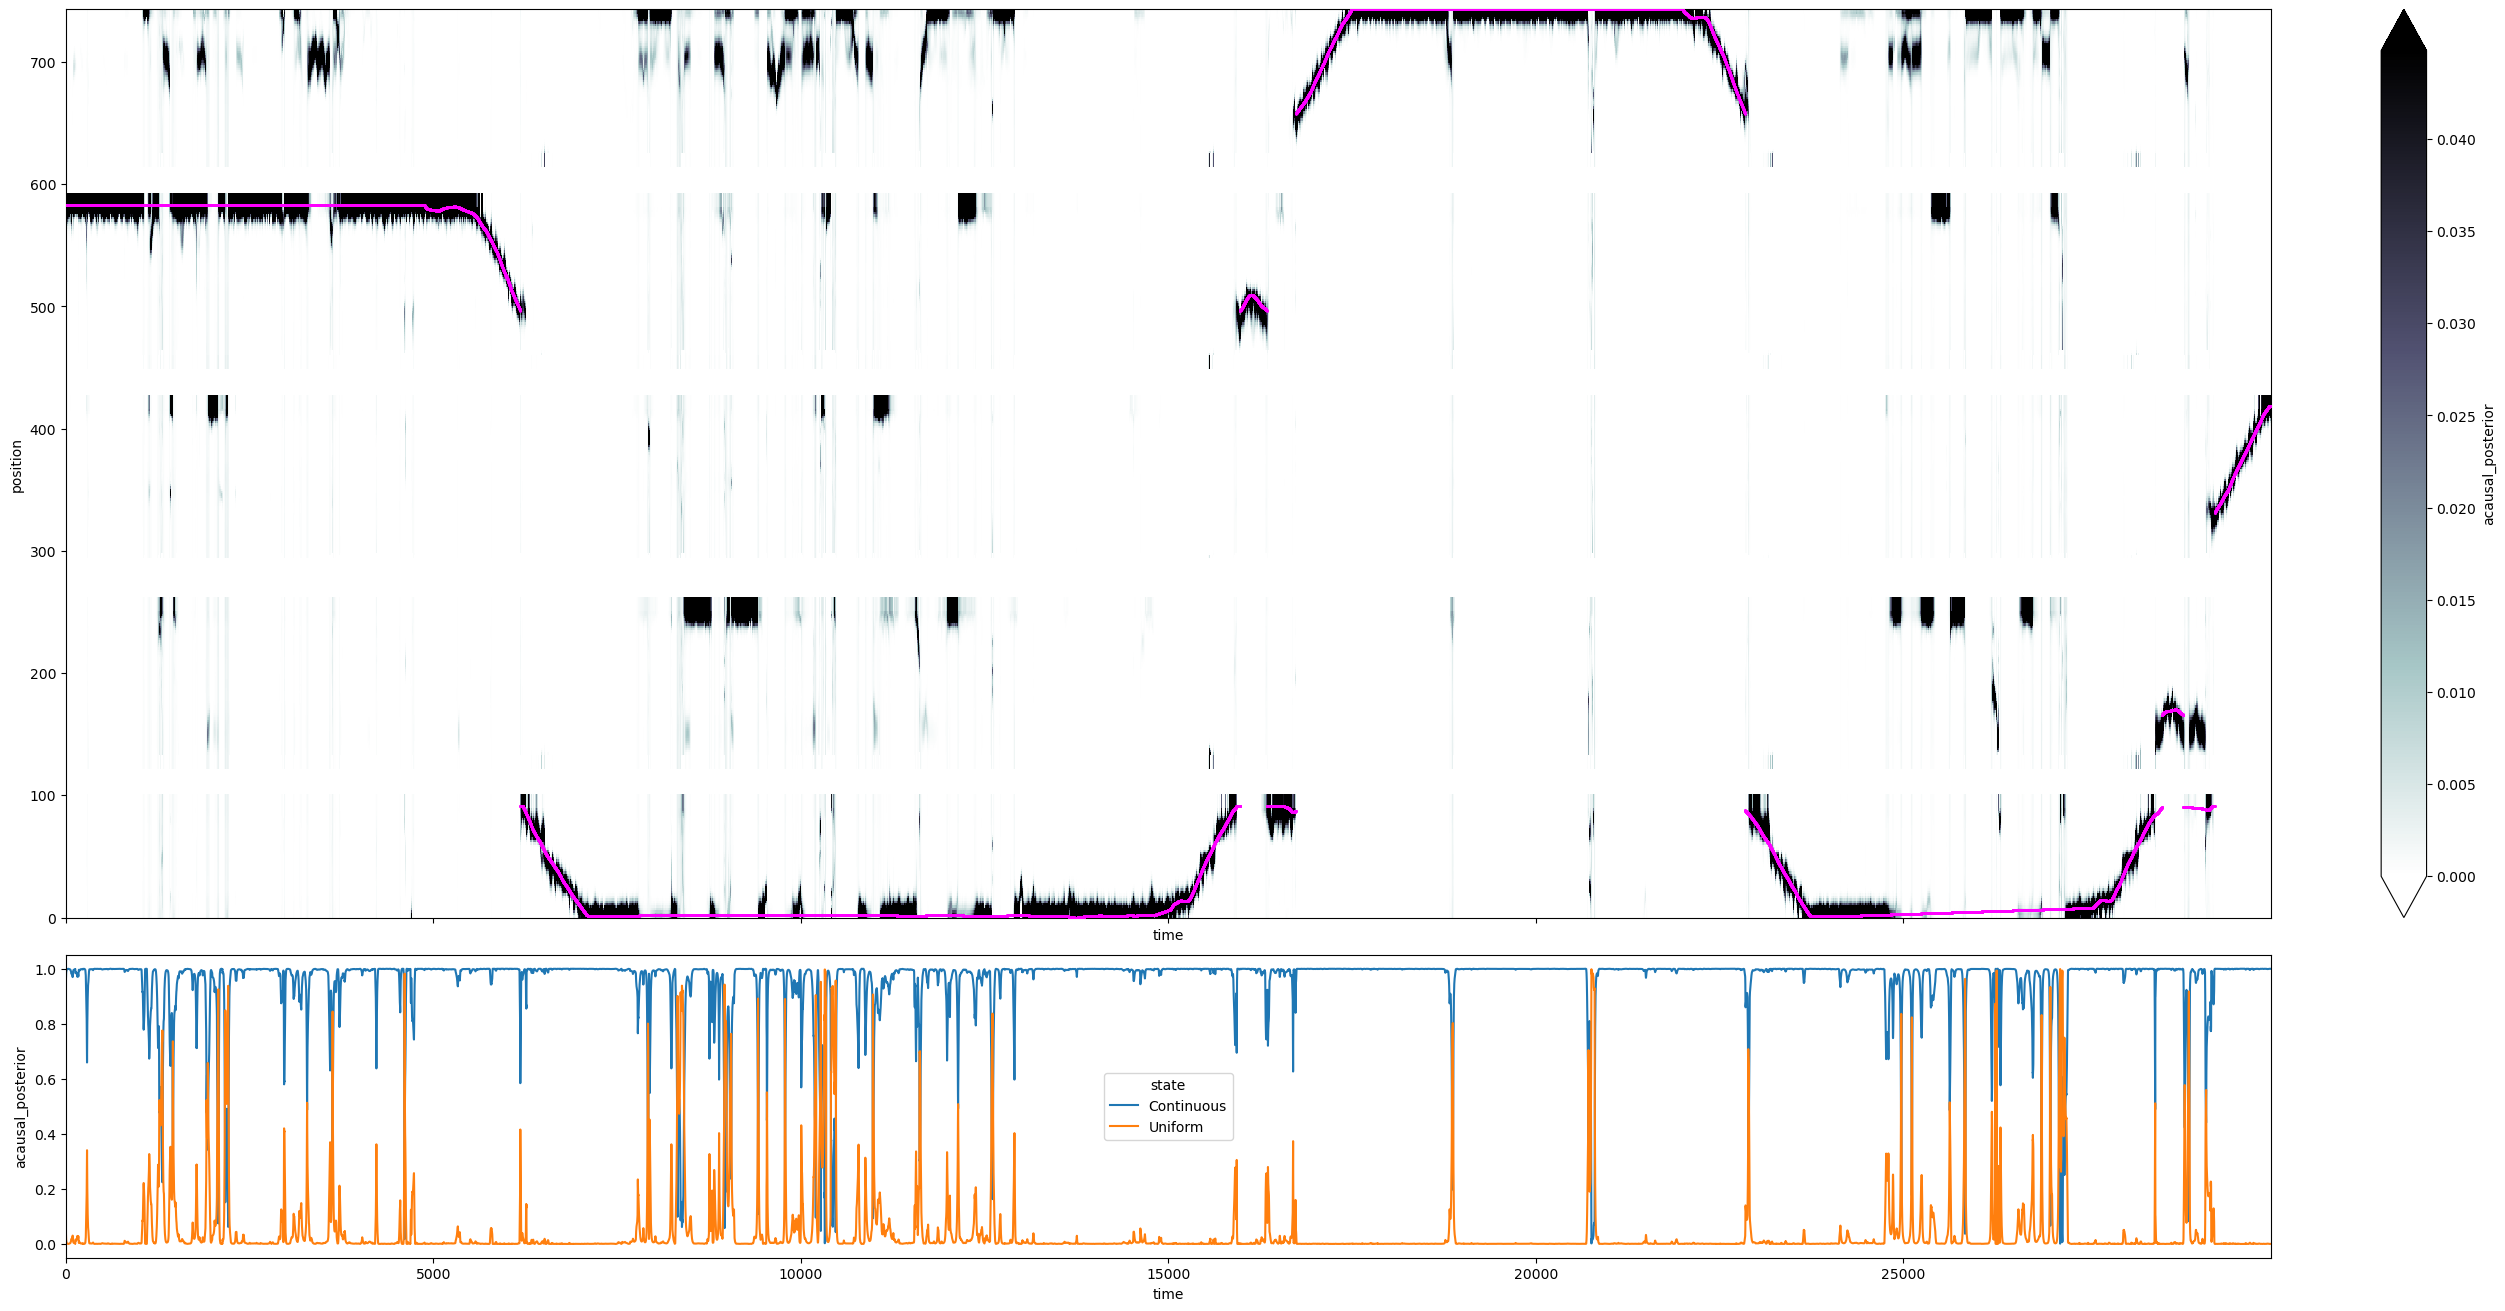

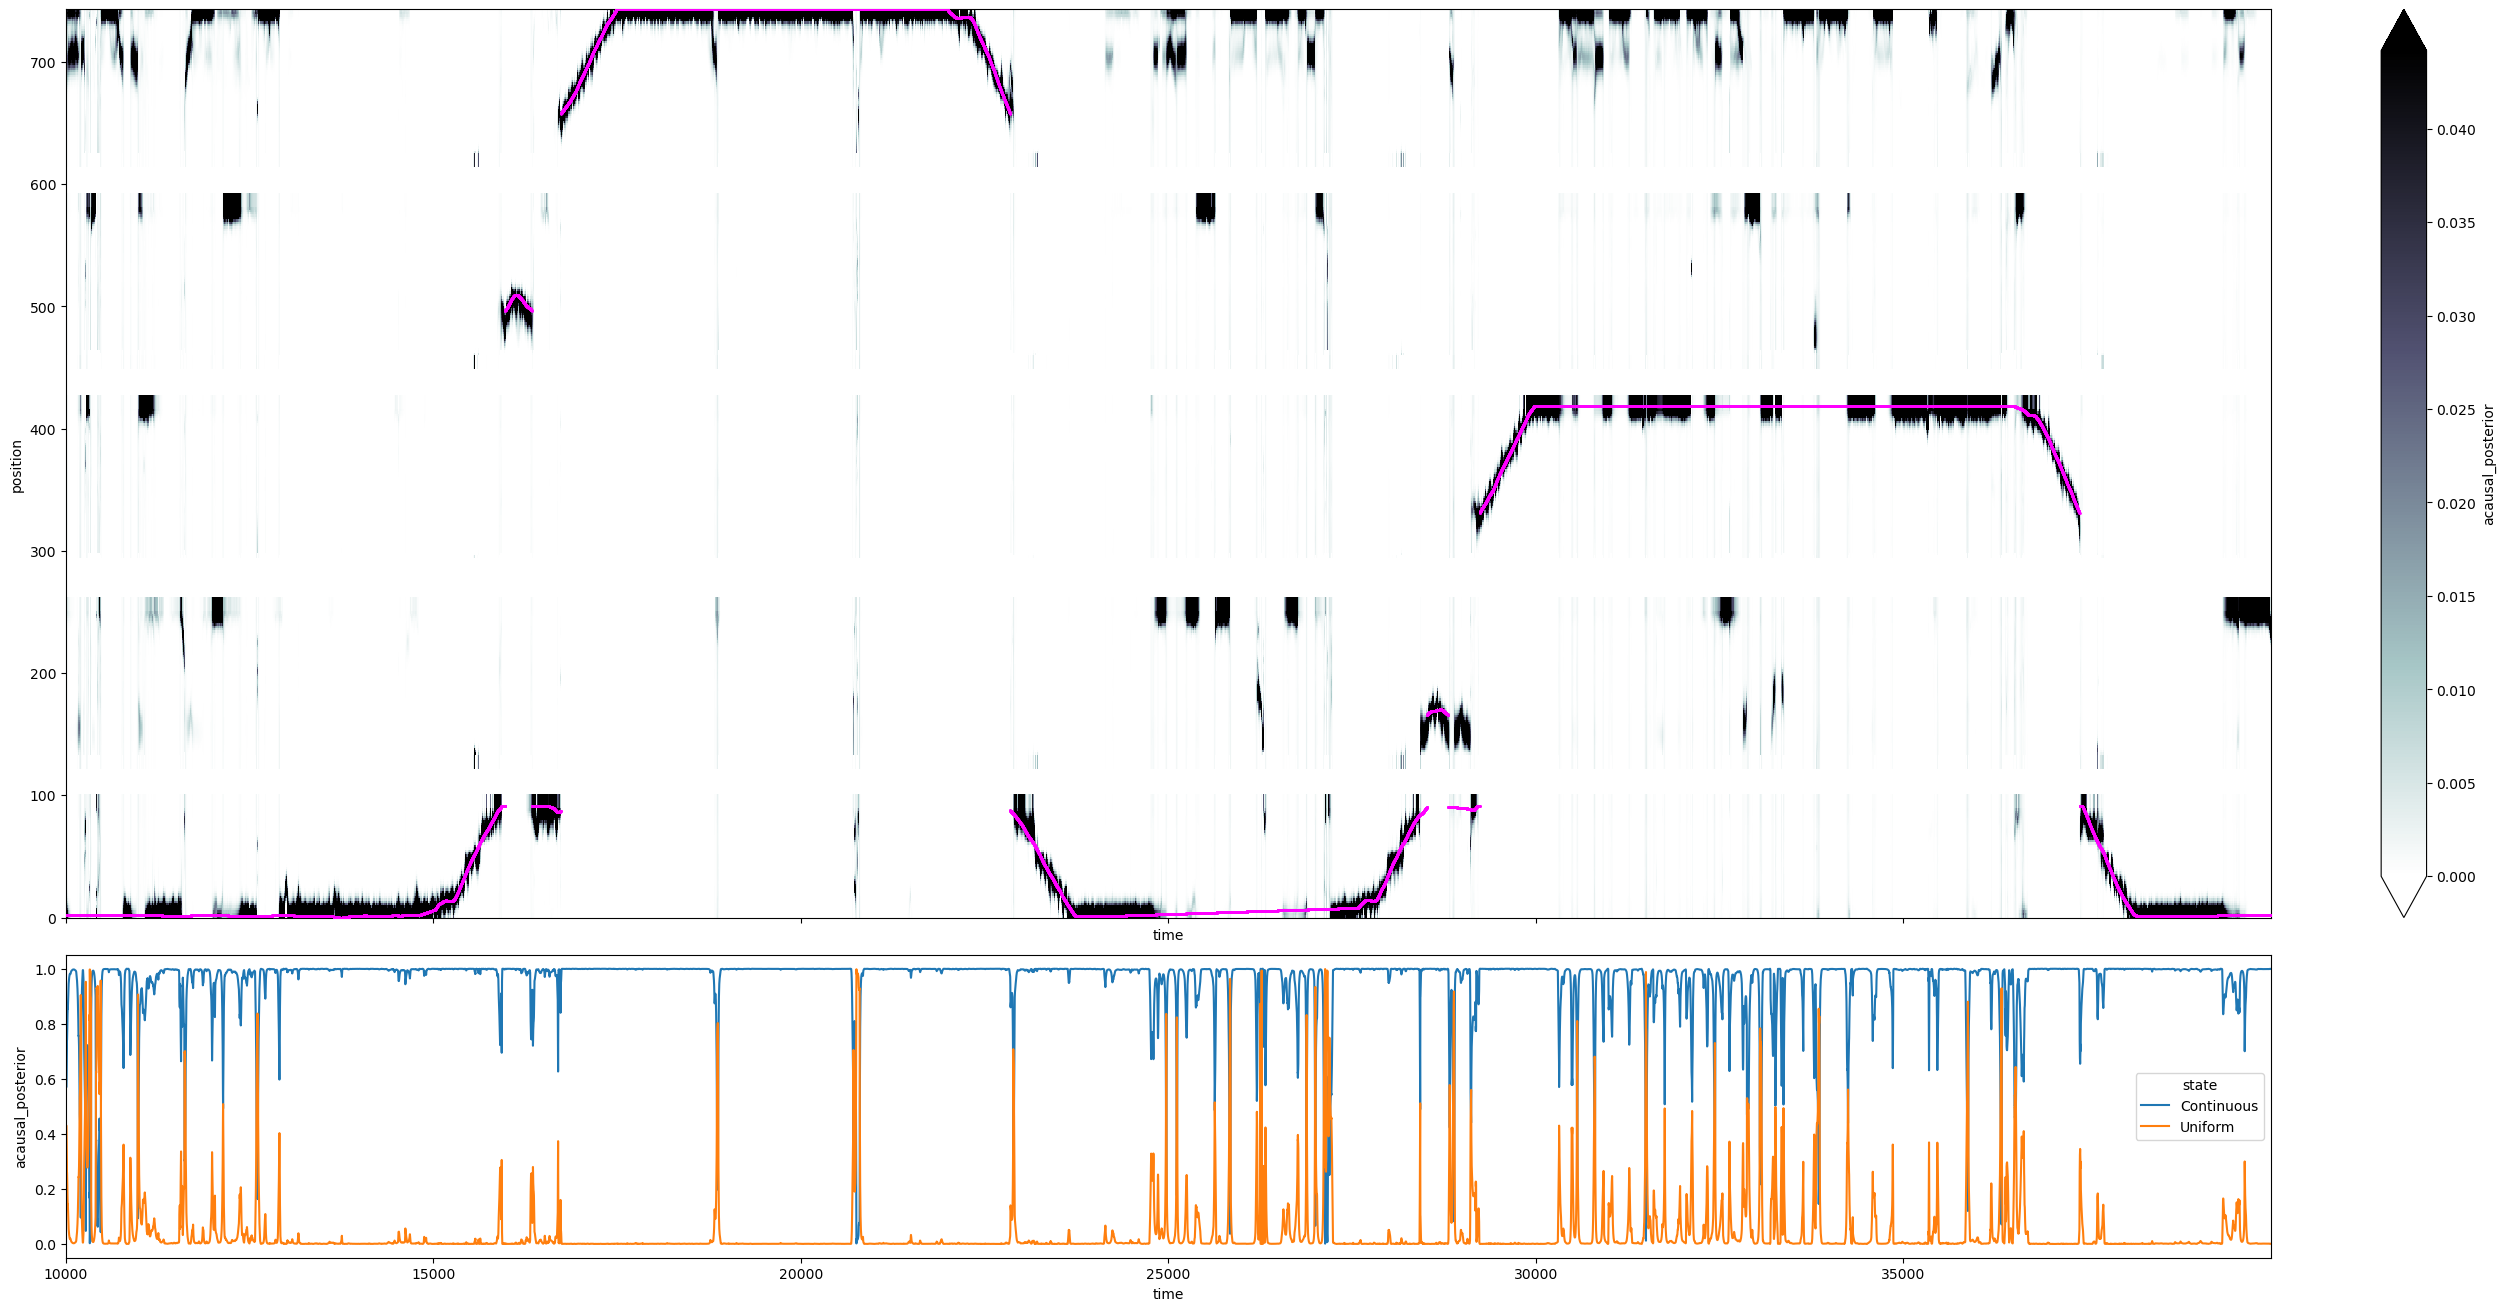

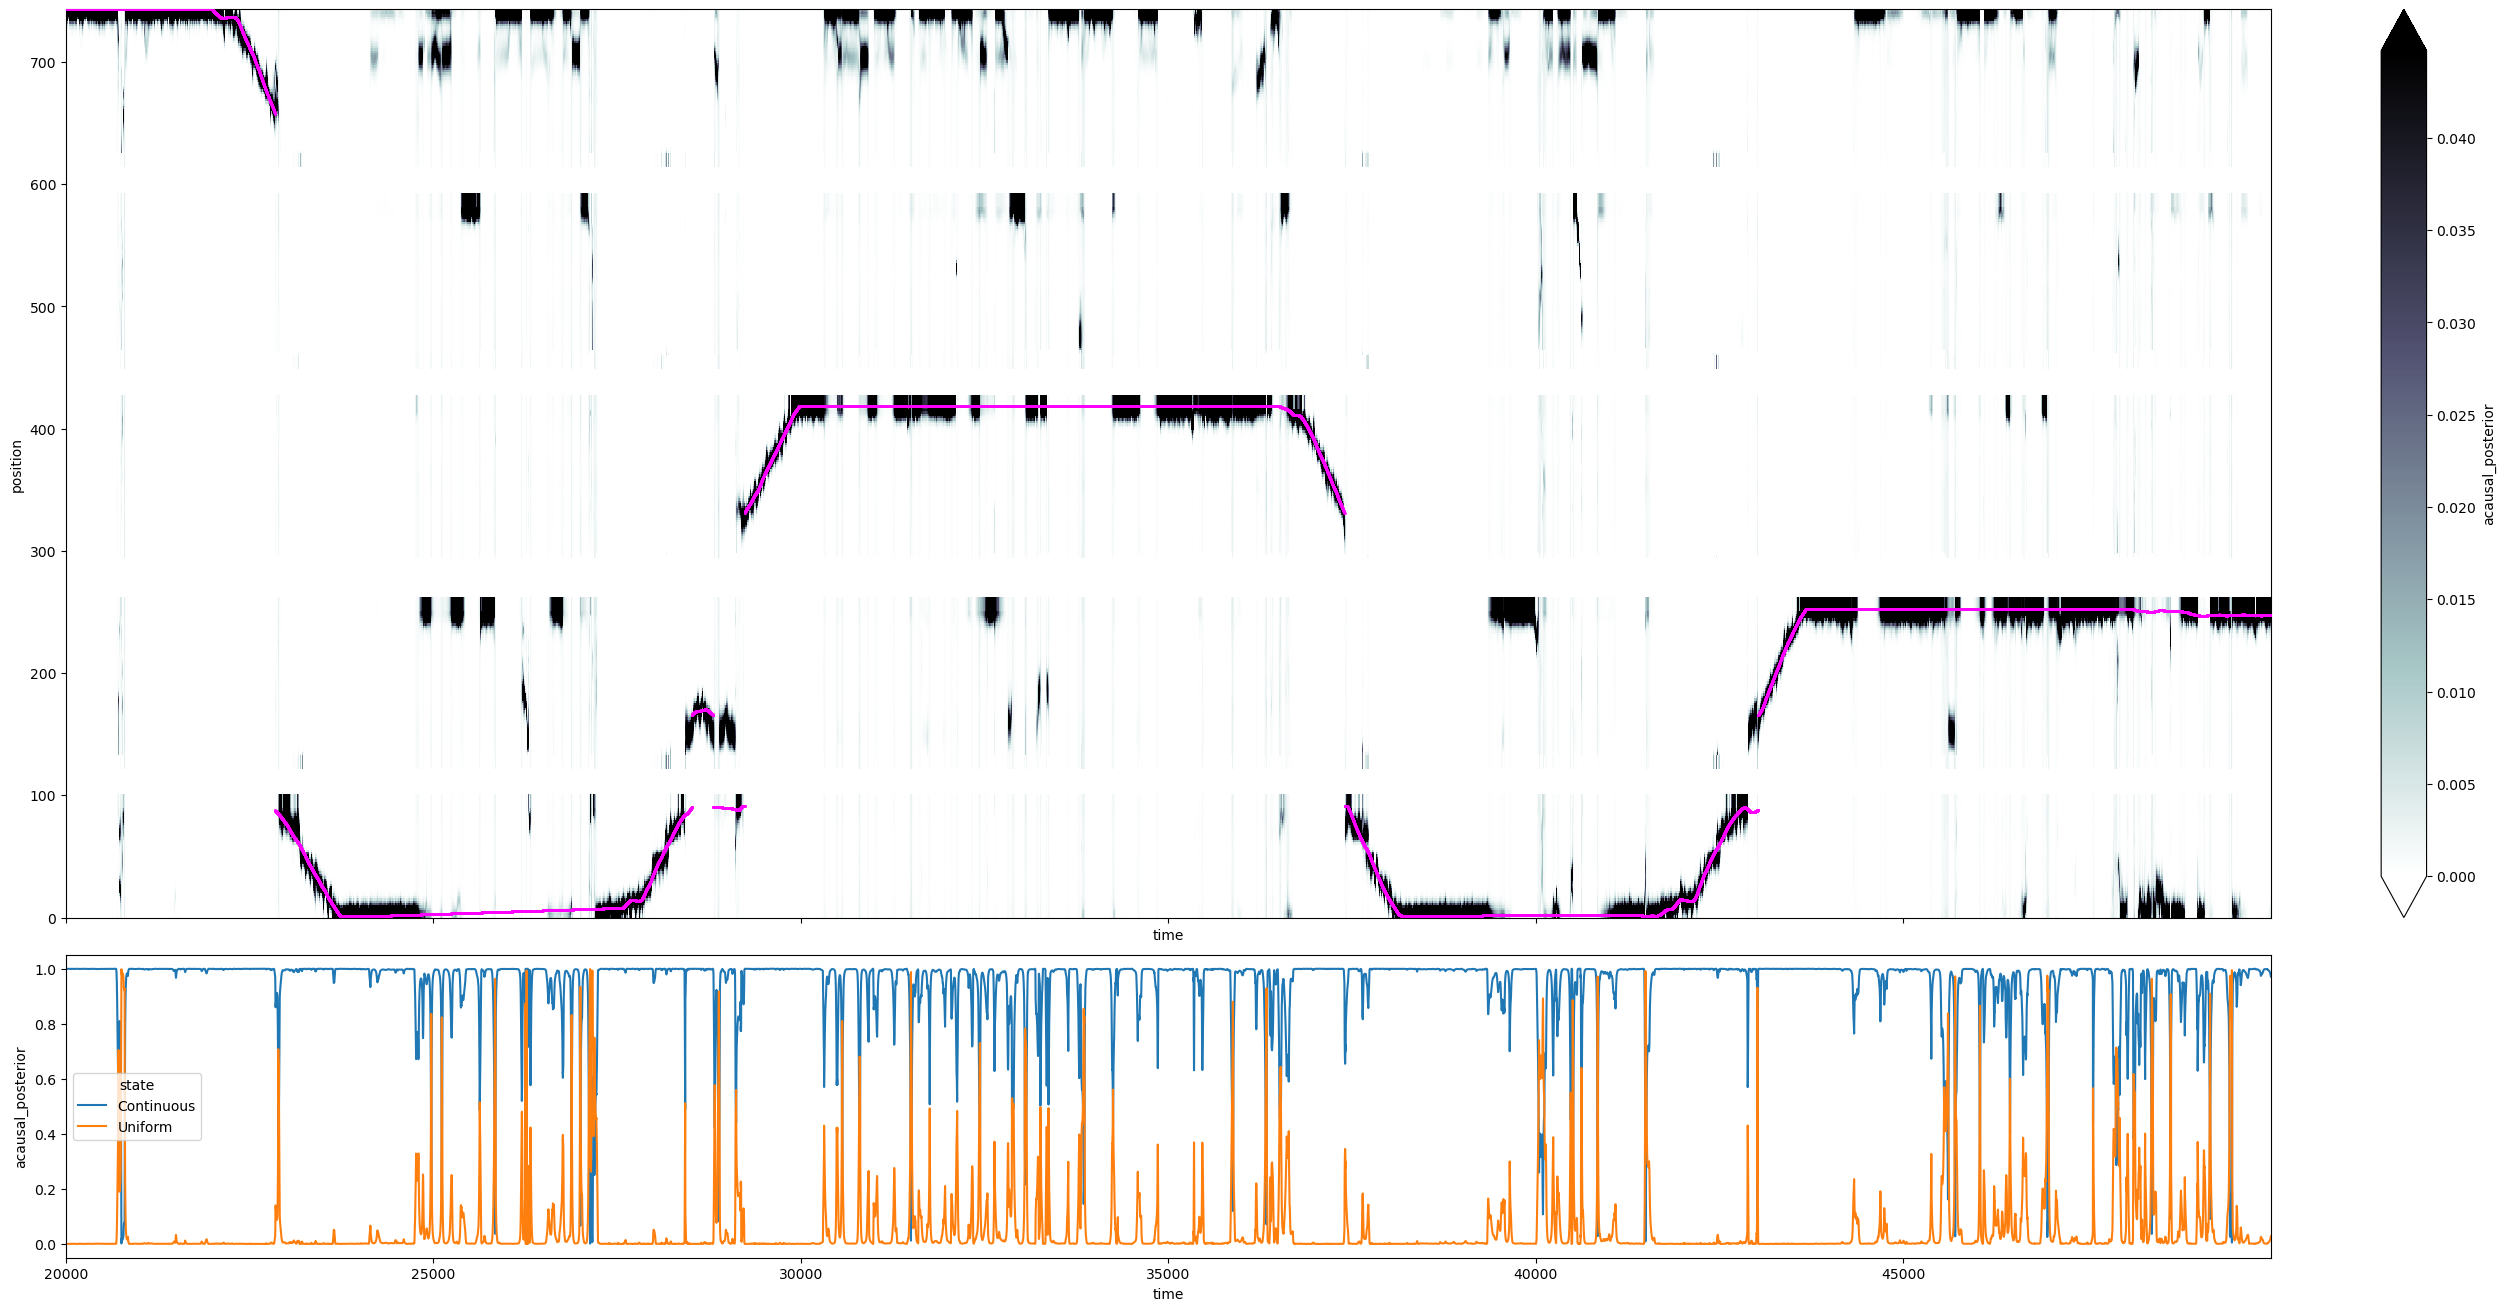

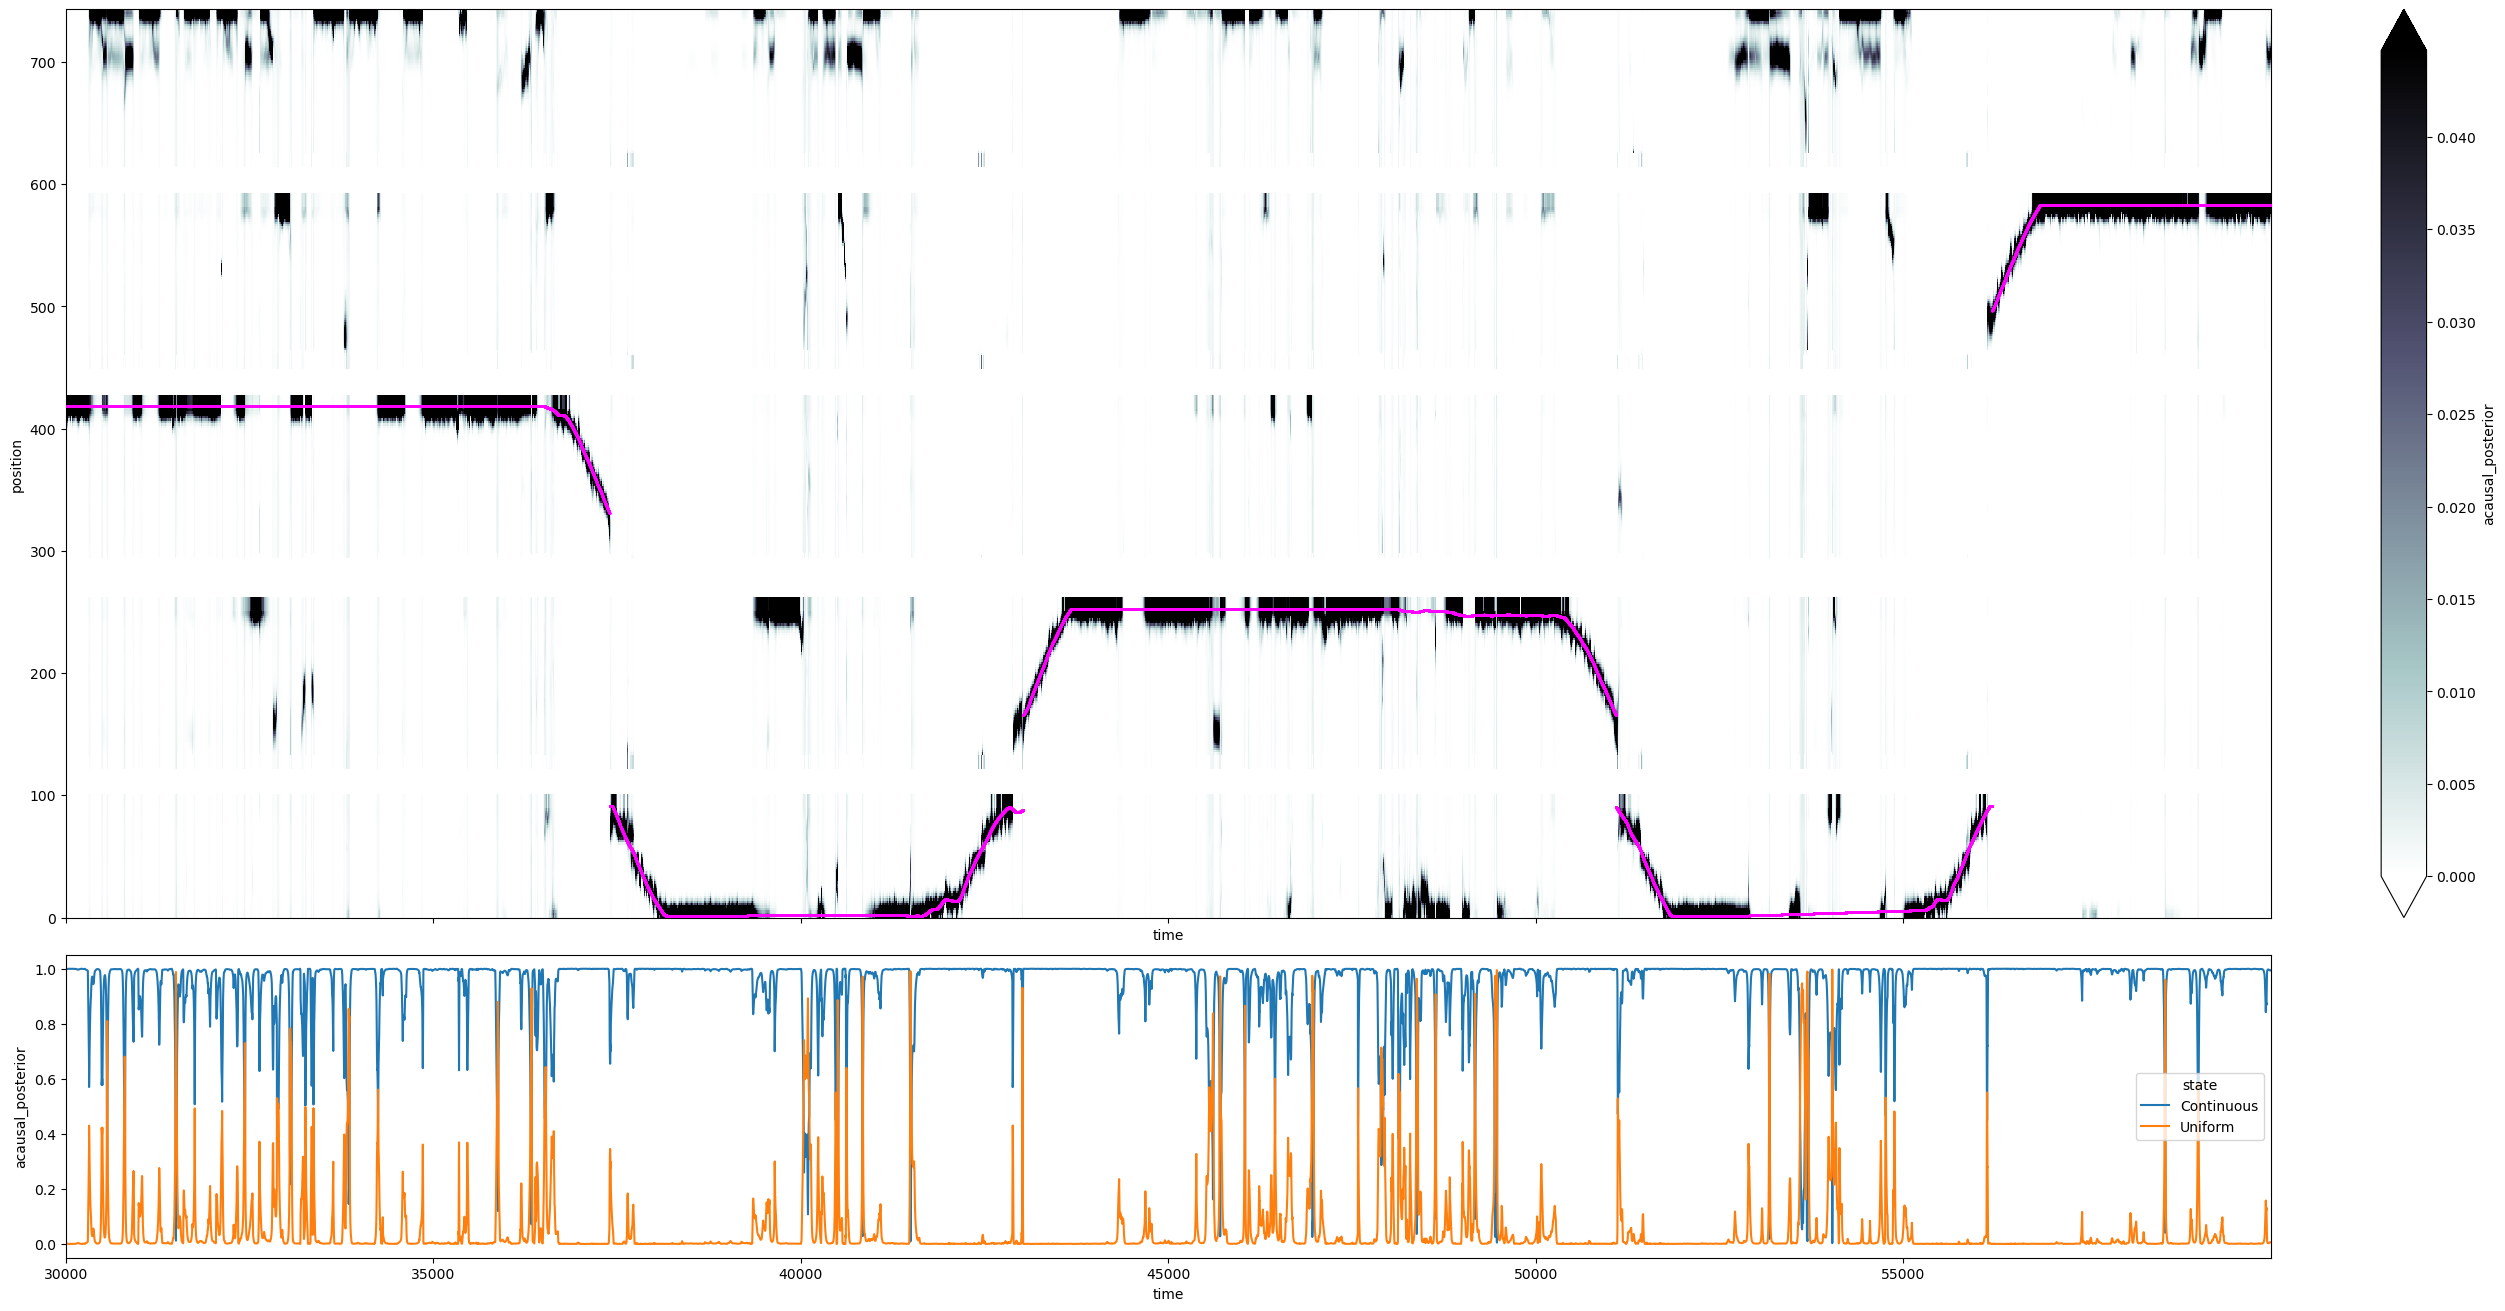

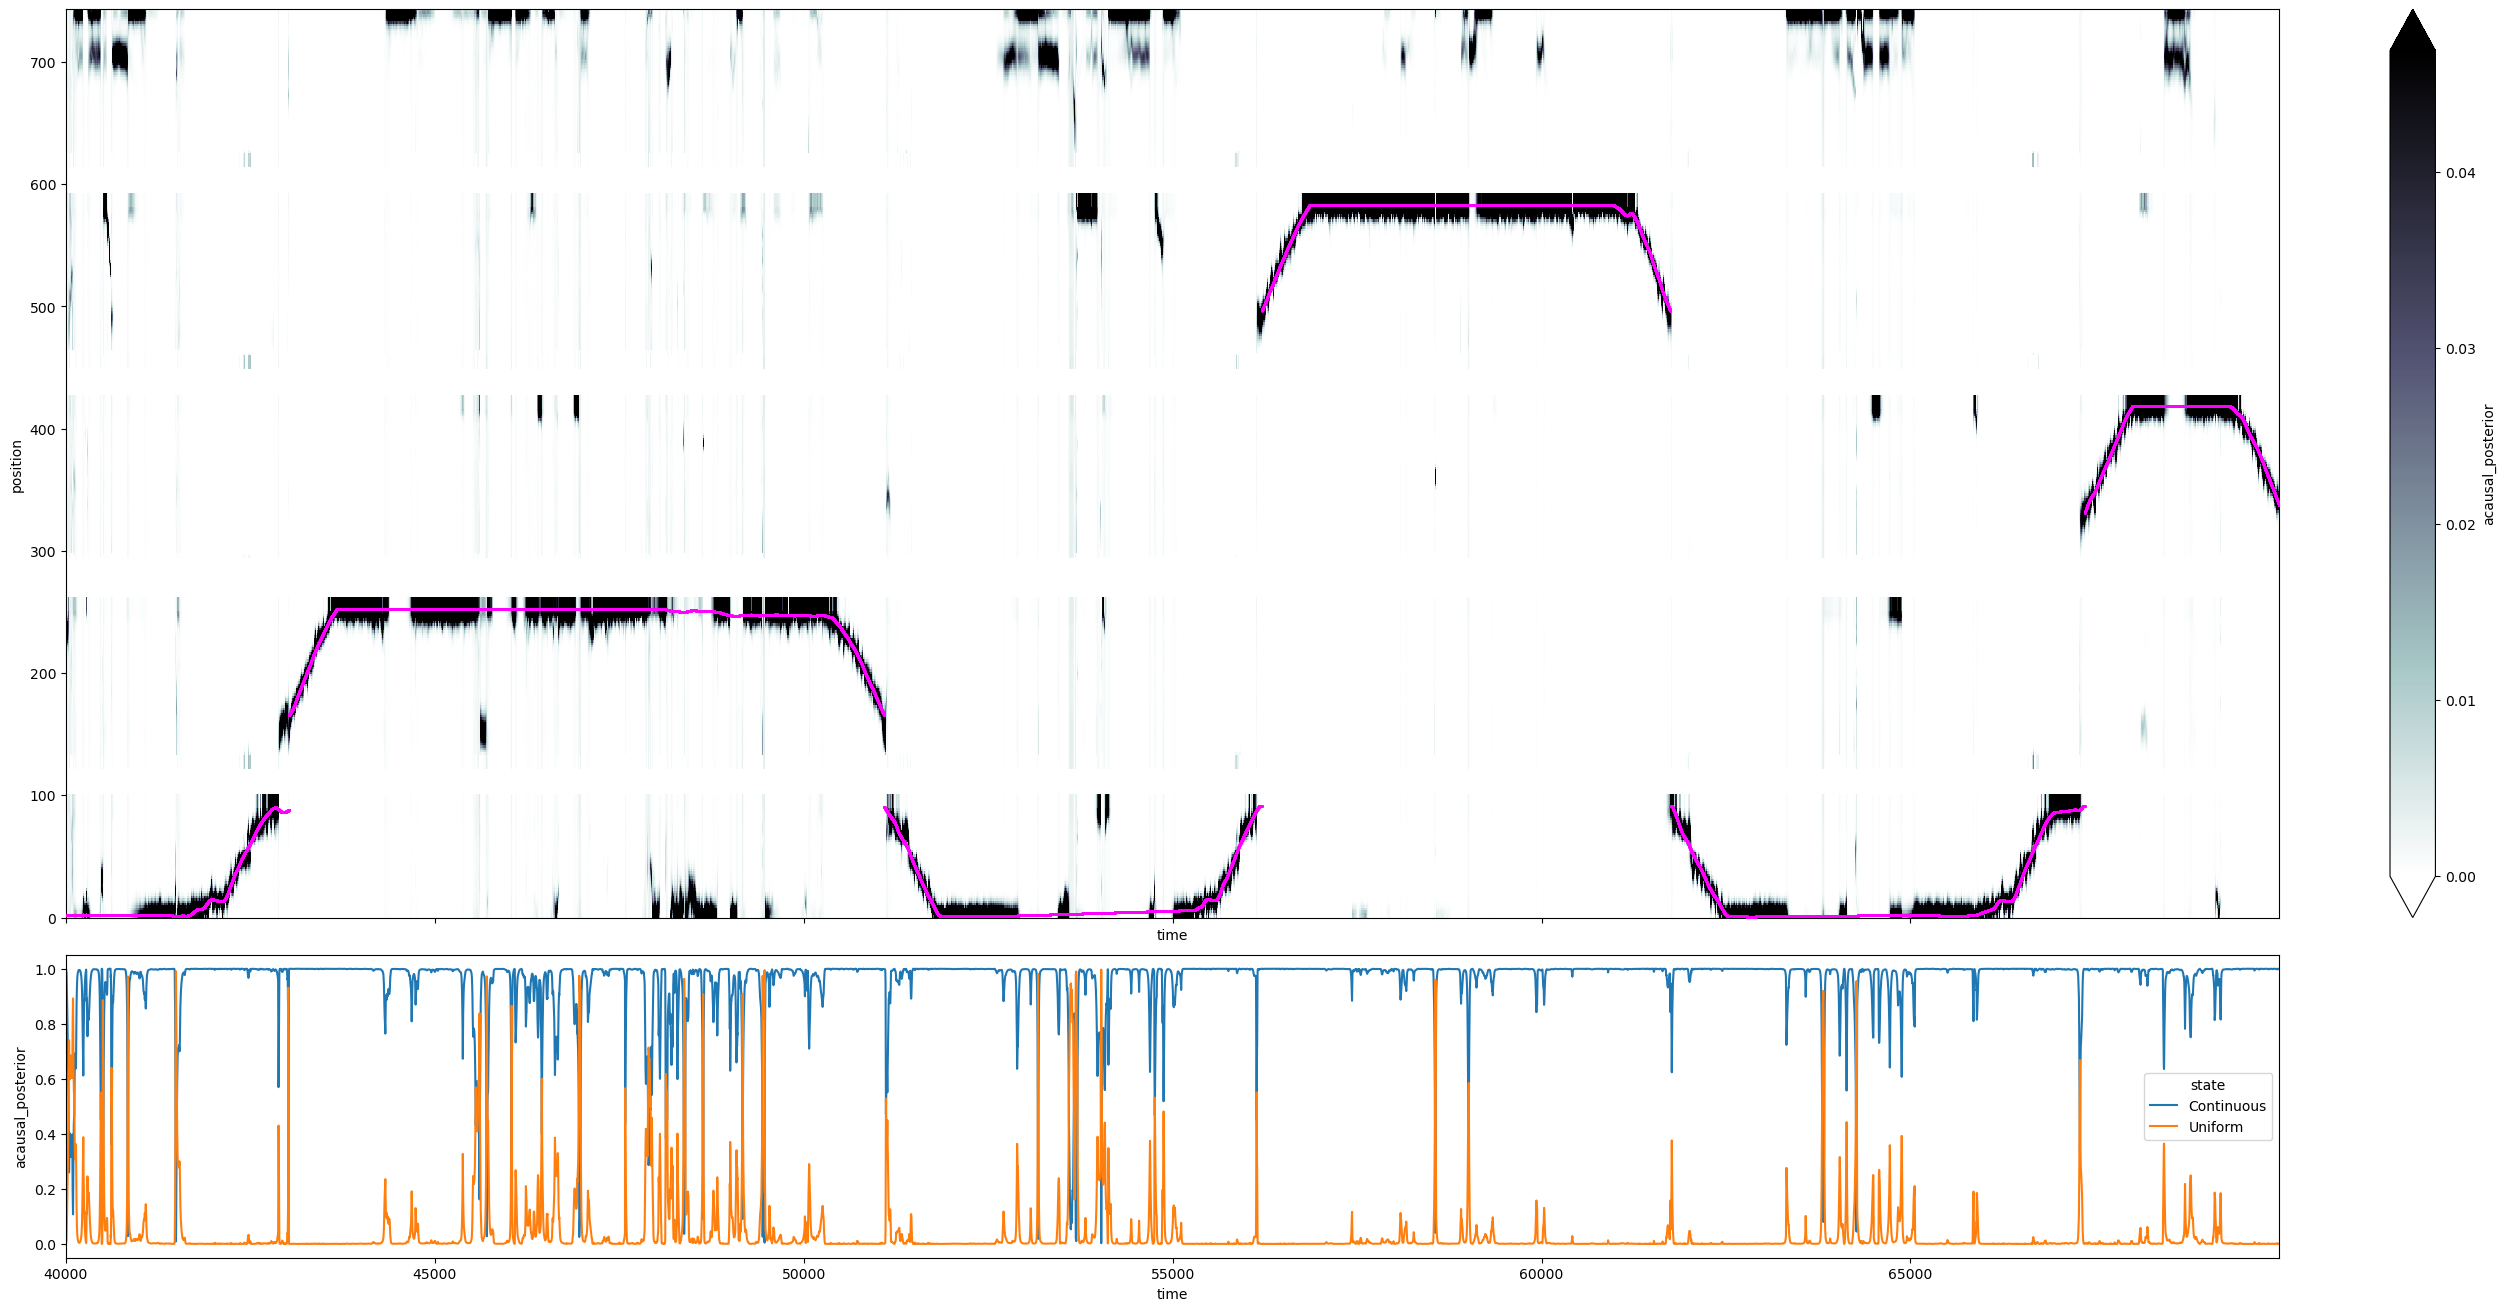

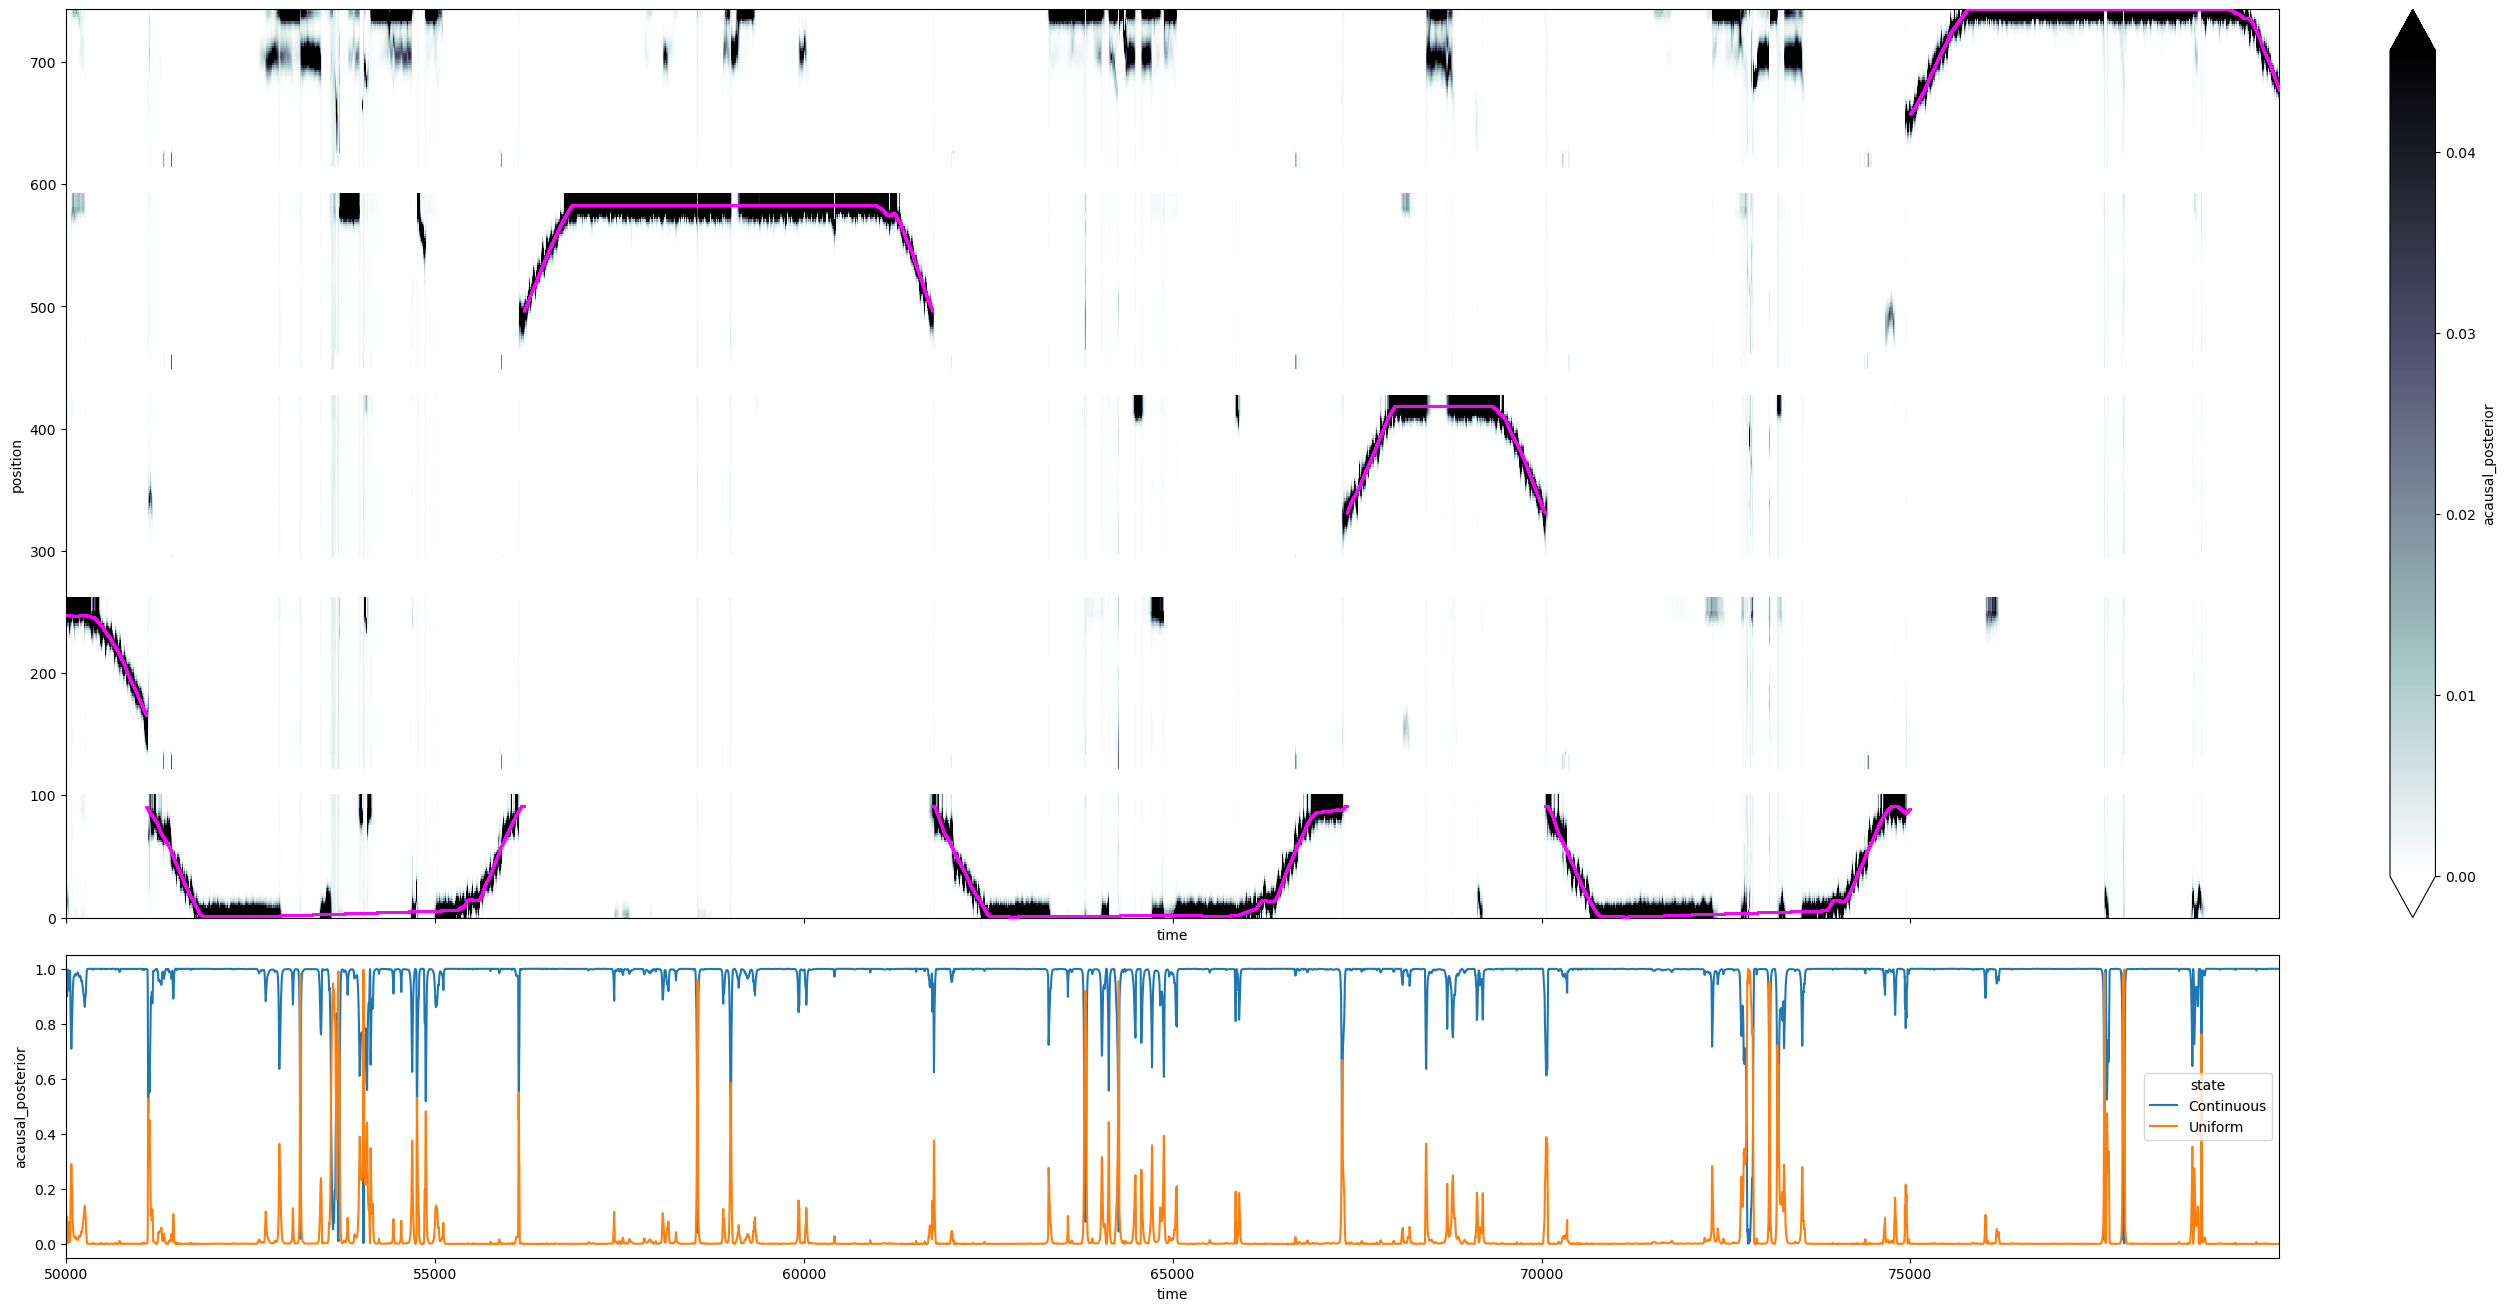

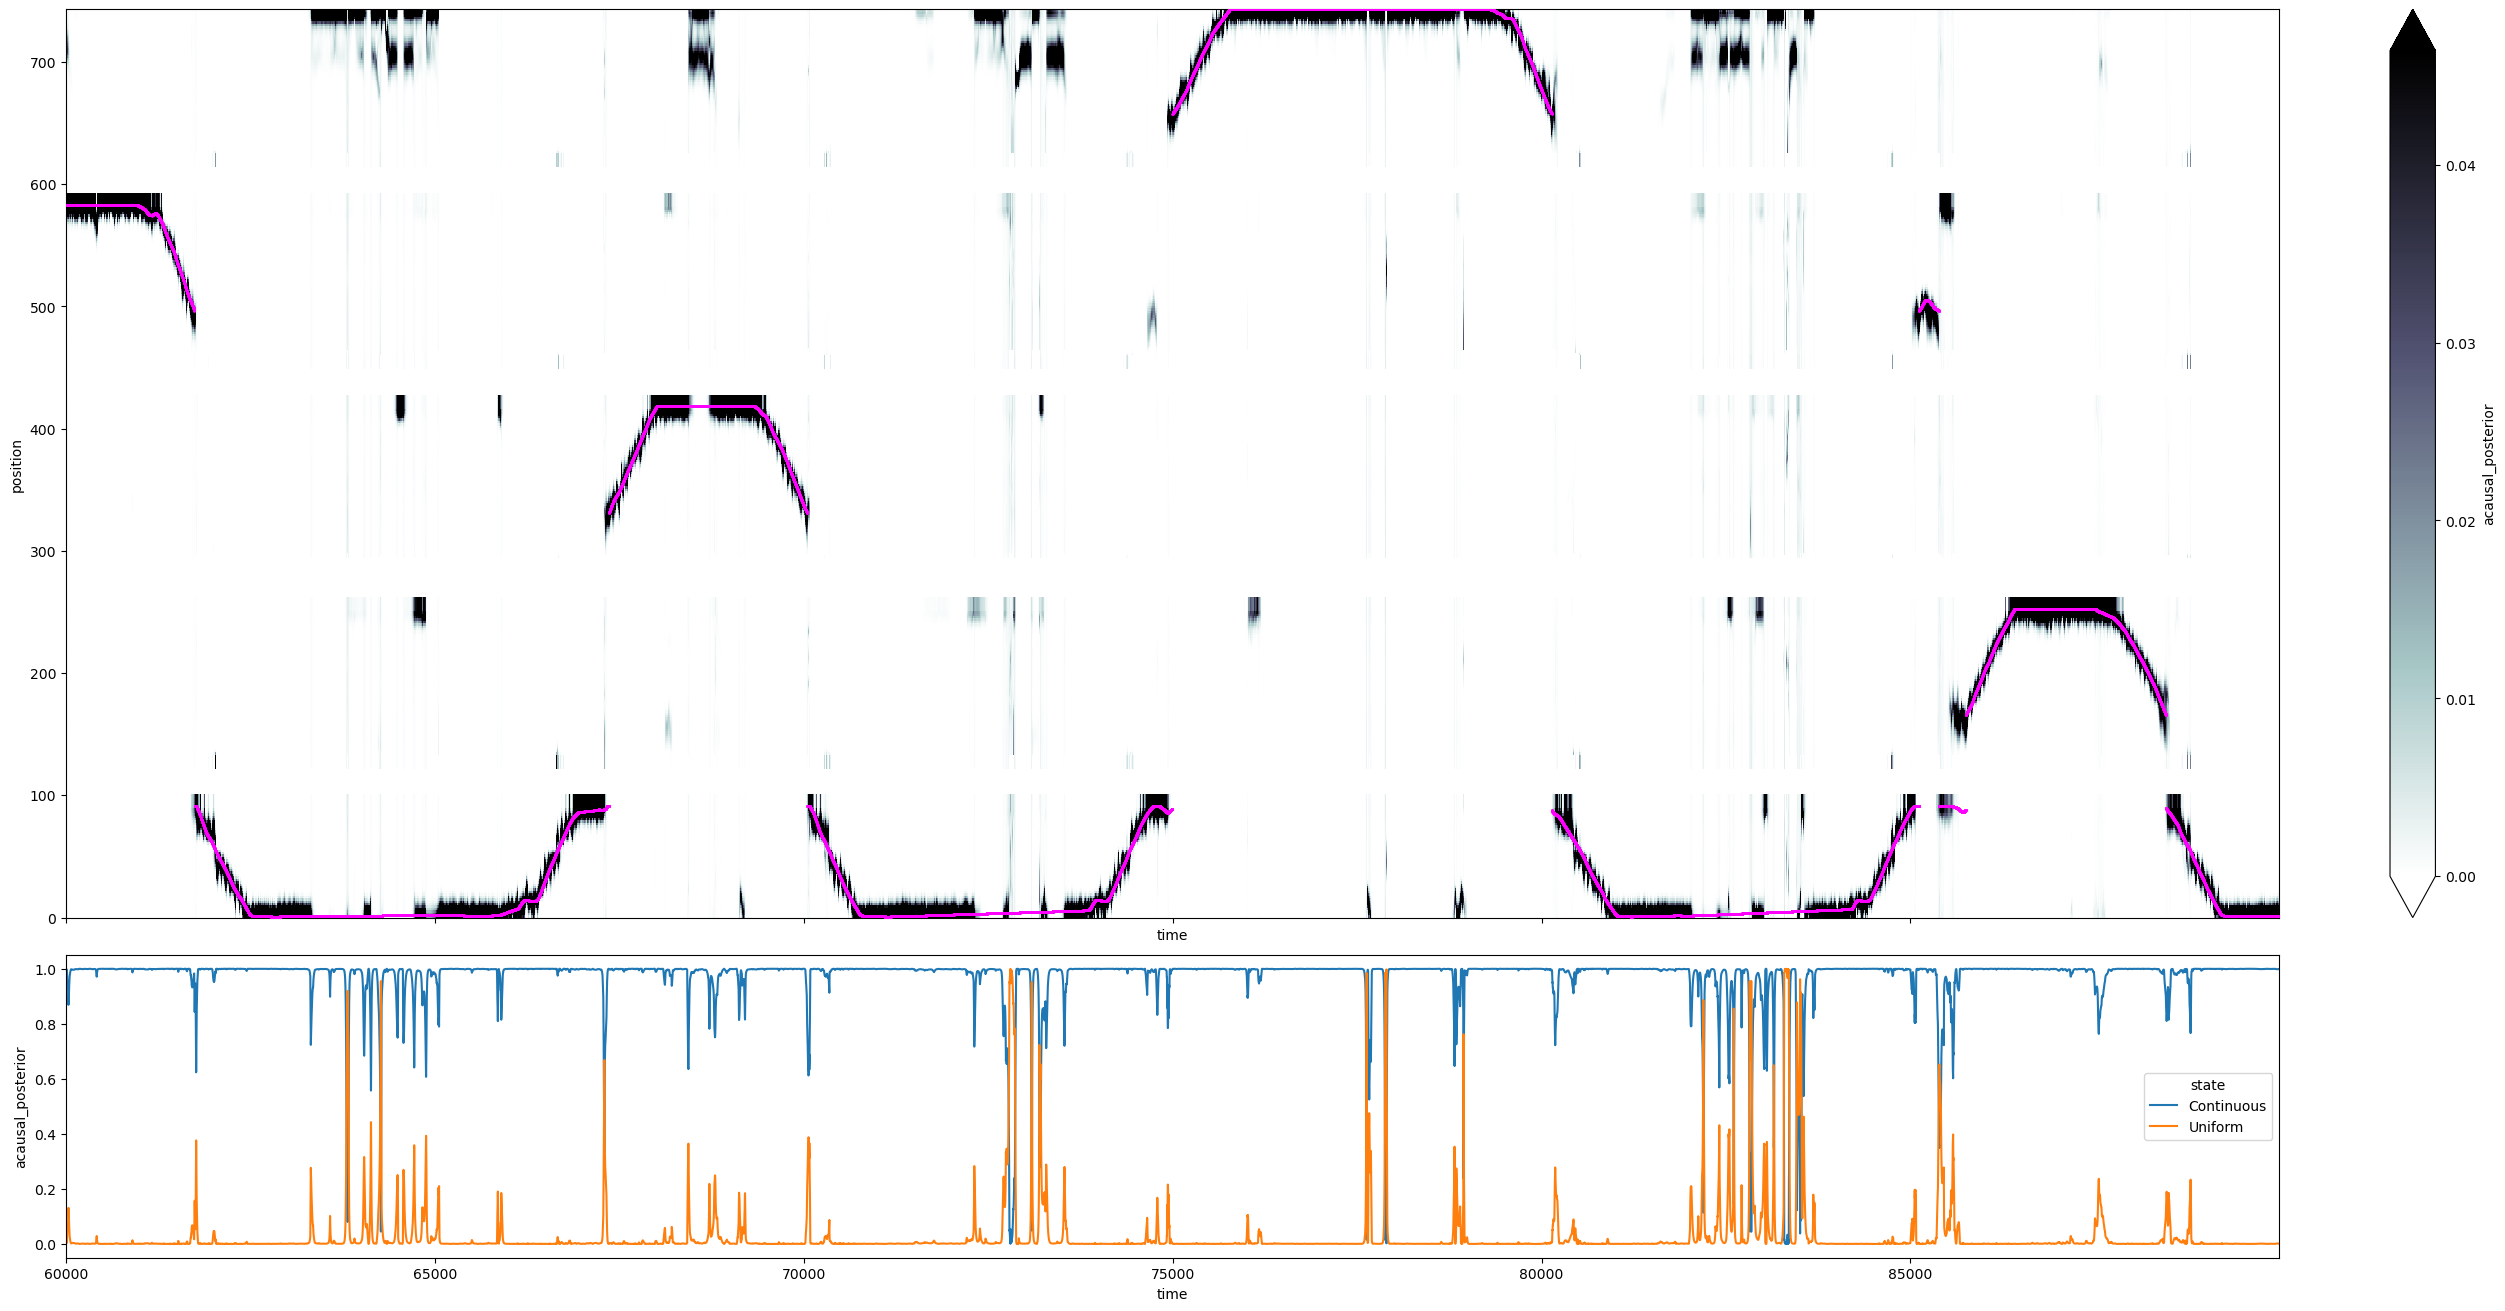

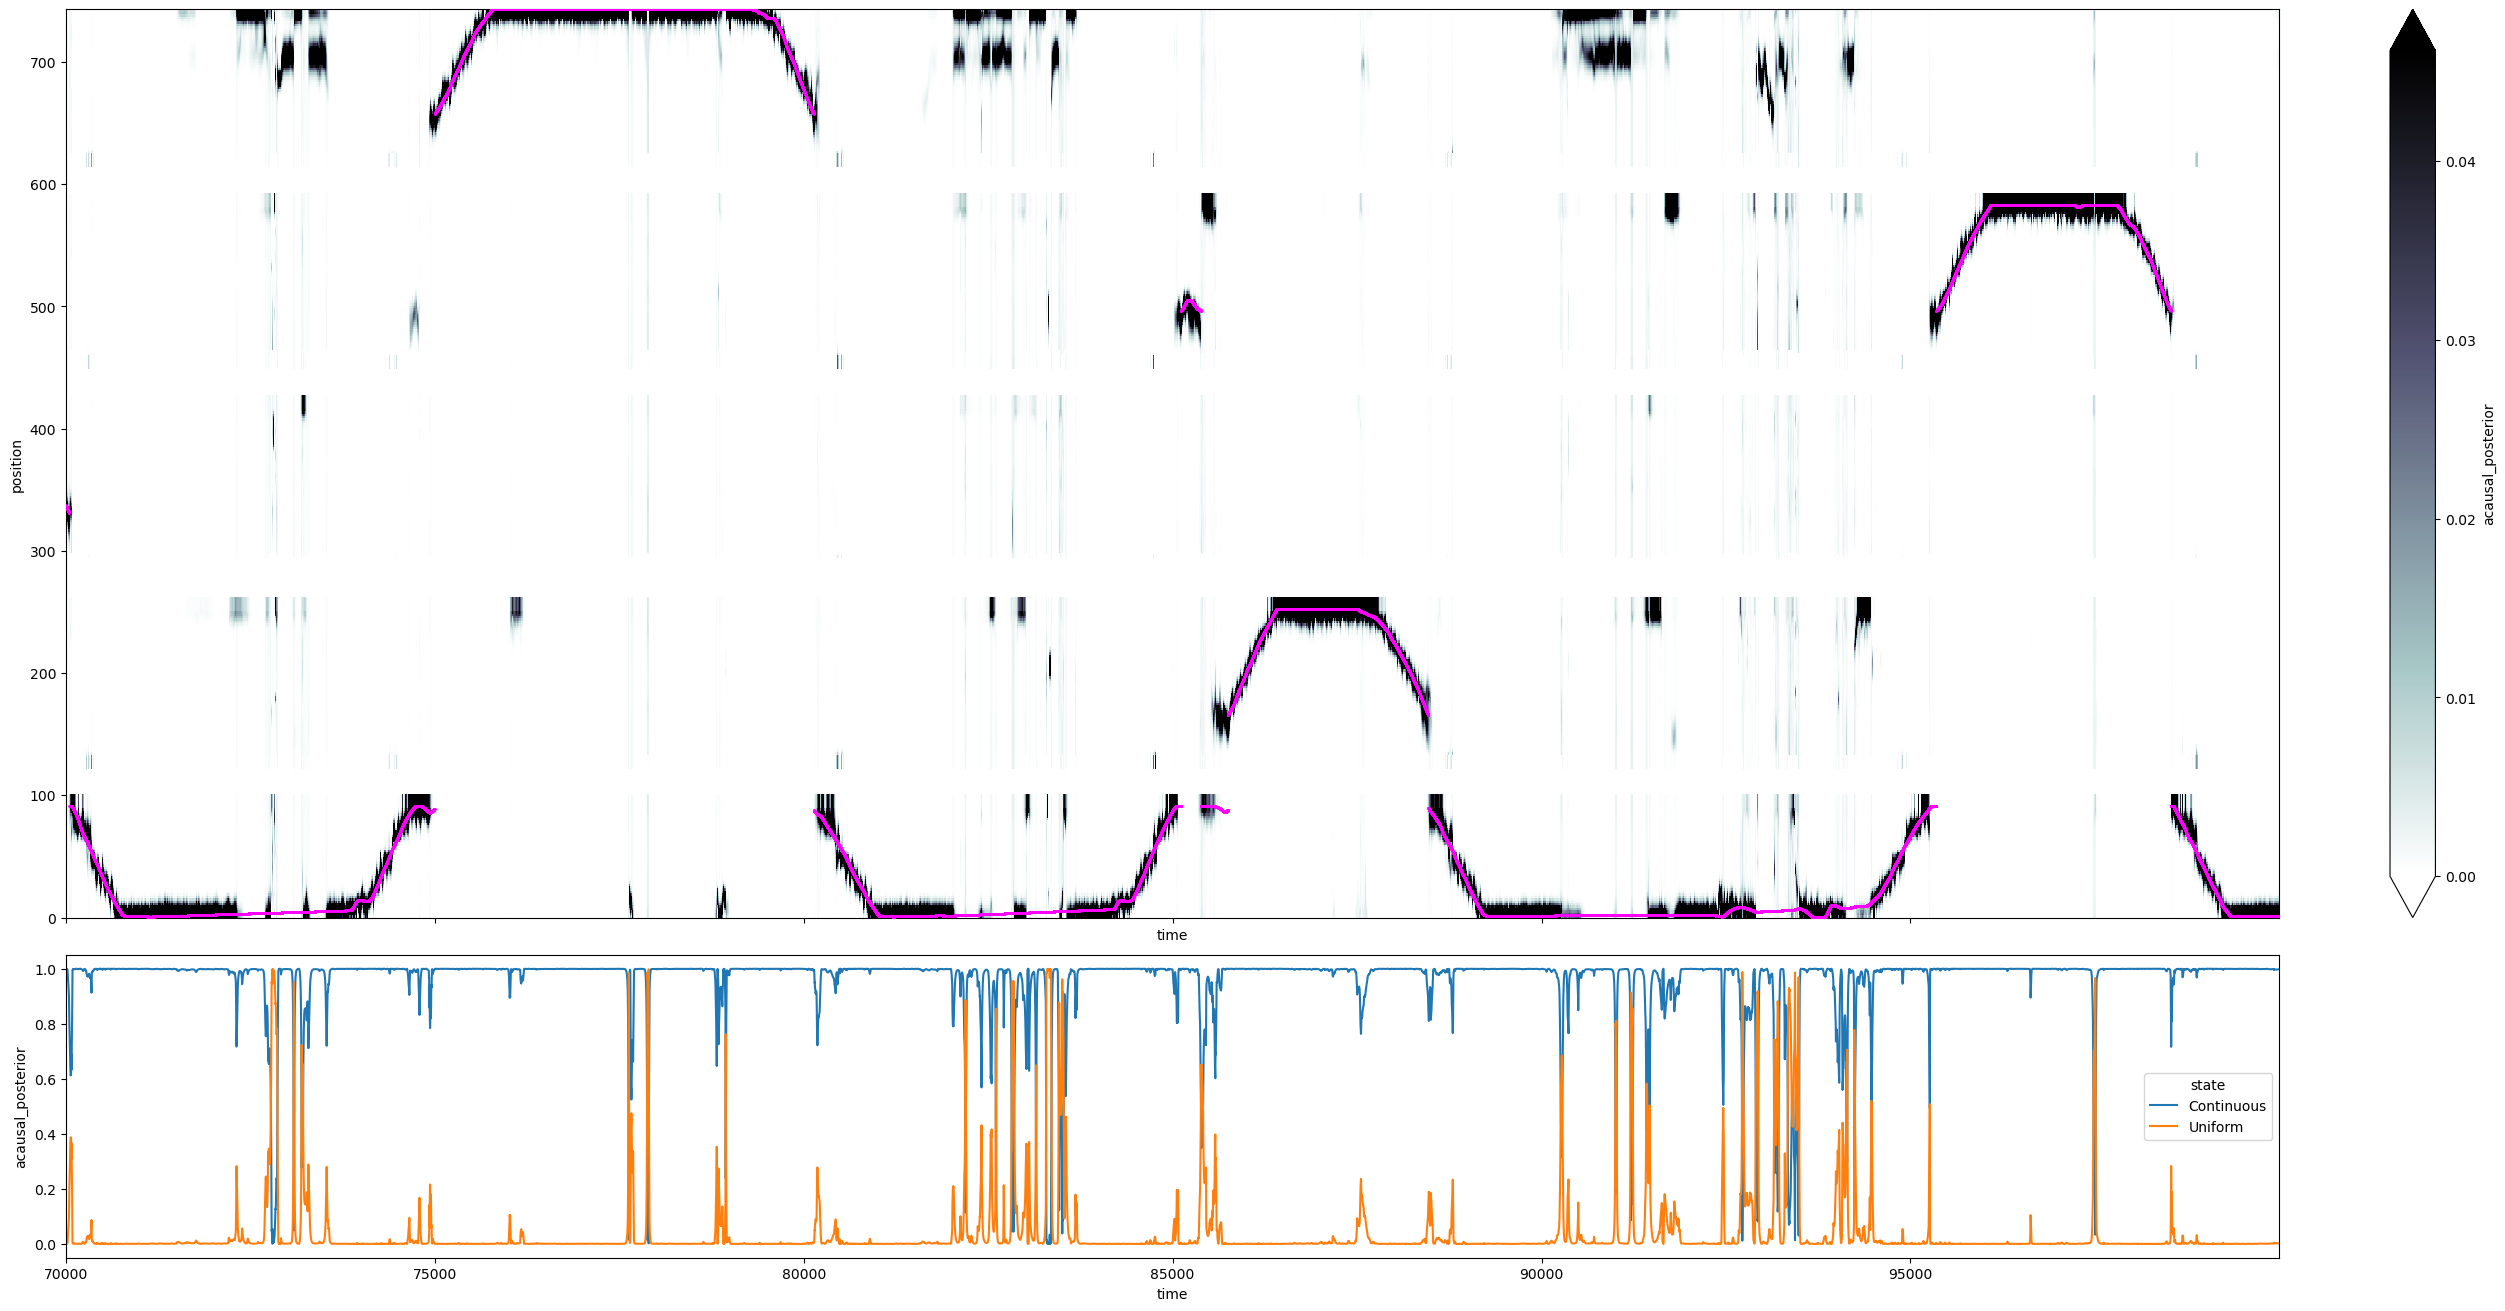

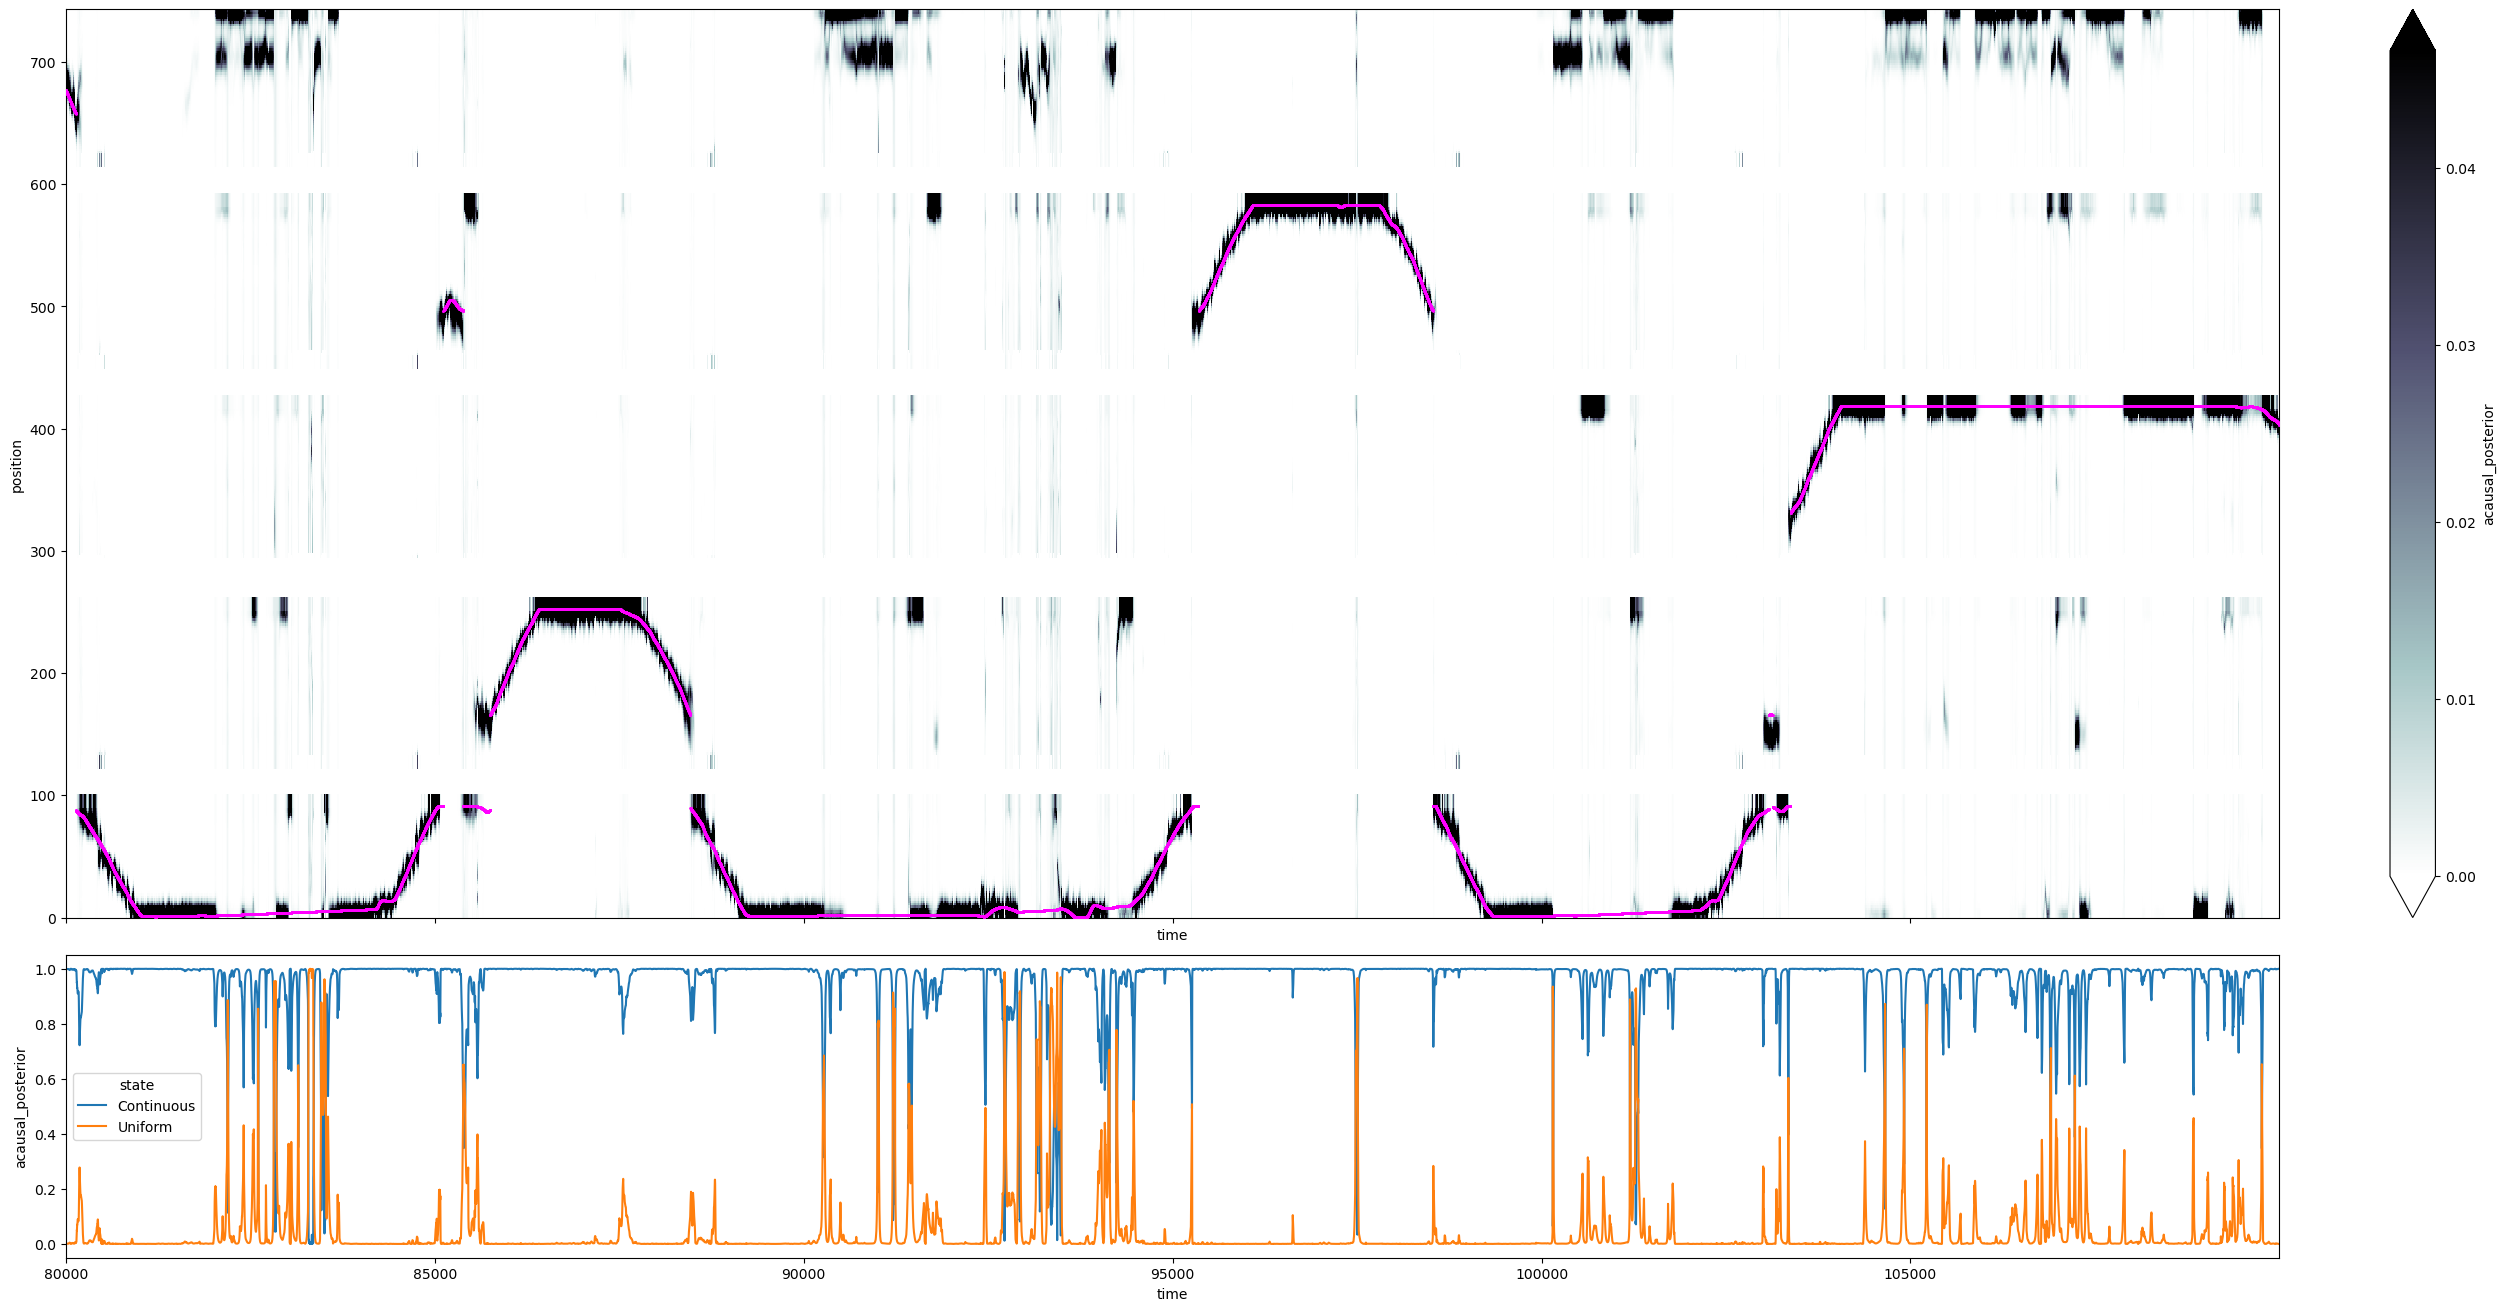

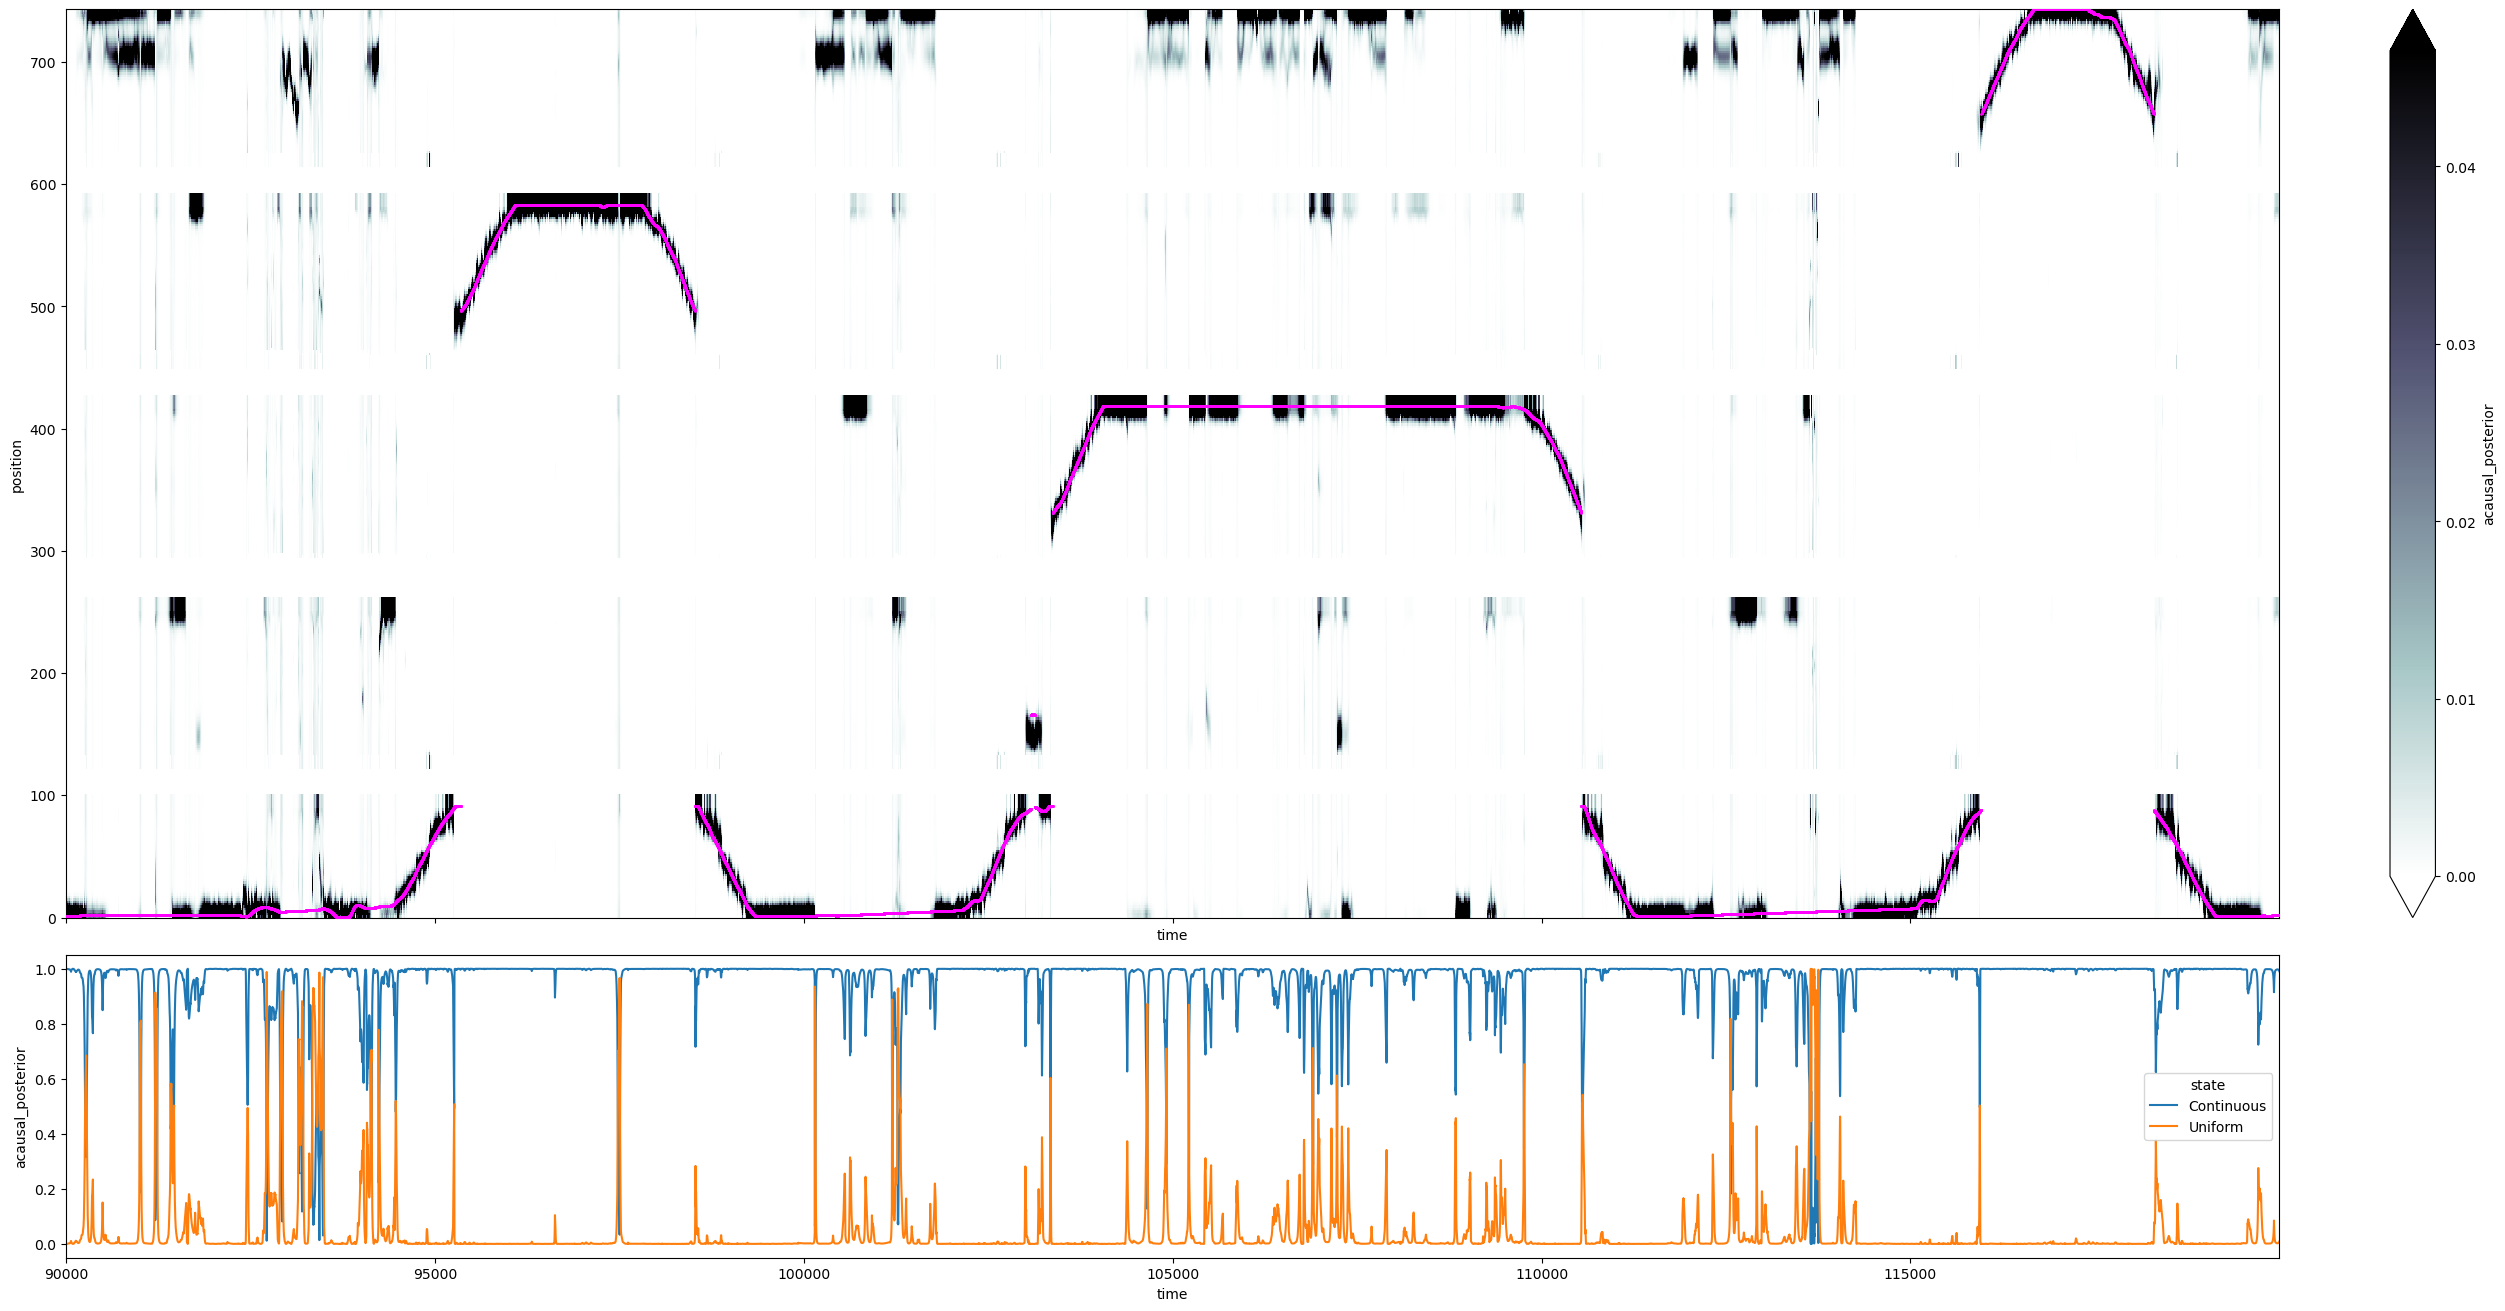

In [94]:
import matplotlib.pyplot as plt
for time_ind in range(0, 100_000, 10_000): #range(0, 600_000, 100_000)
    time_slice = slice(time_ind, time_ind + 30_000)

    fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)
    results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
    axes[0].scatter(position_1d.iloc[time_slice].index,
                    position_1d.iloc[time_slice].linear_position.values,
                    s=1, color='magenta', zorder=10)
 
    results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

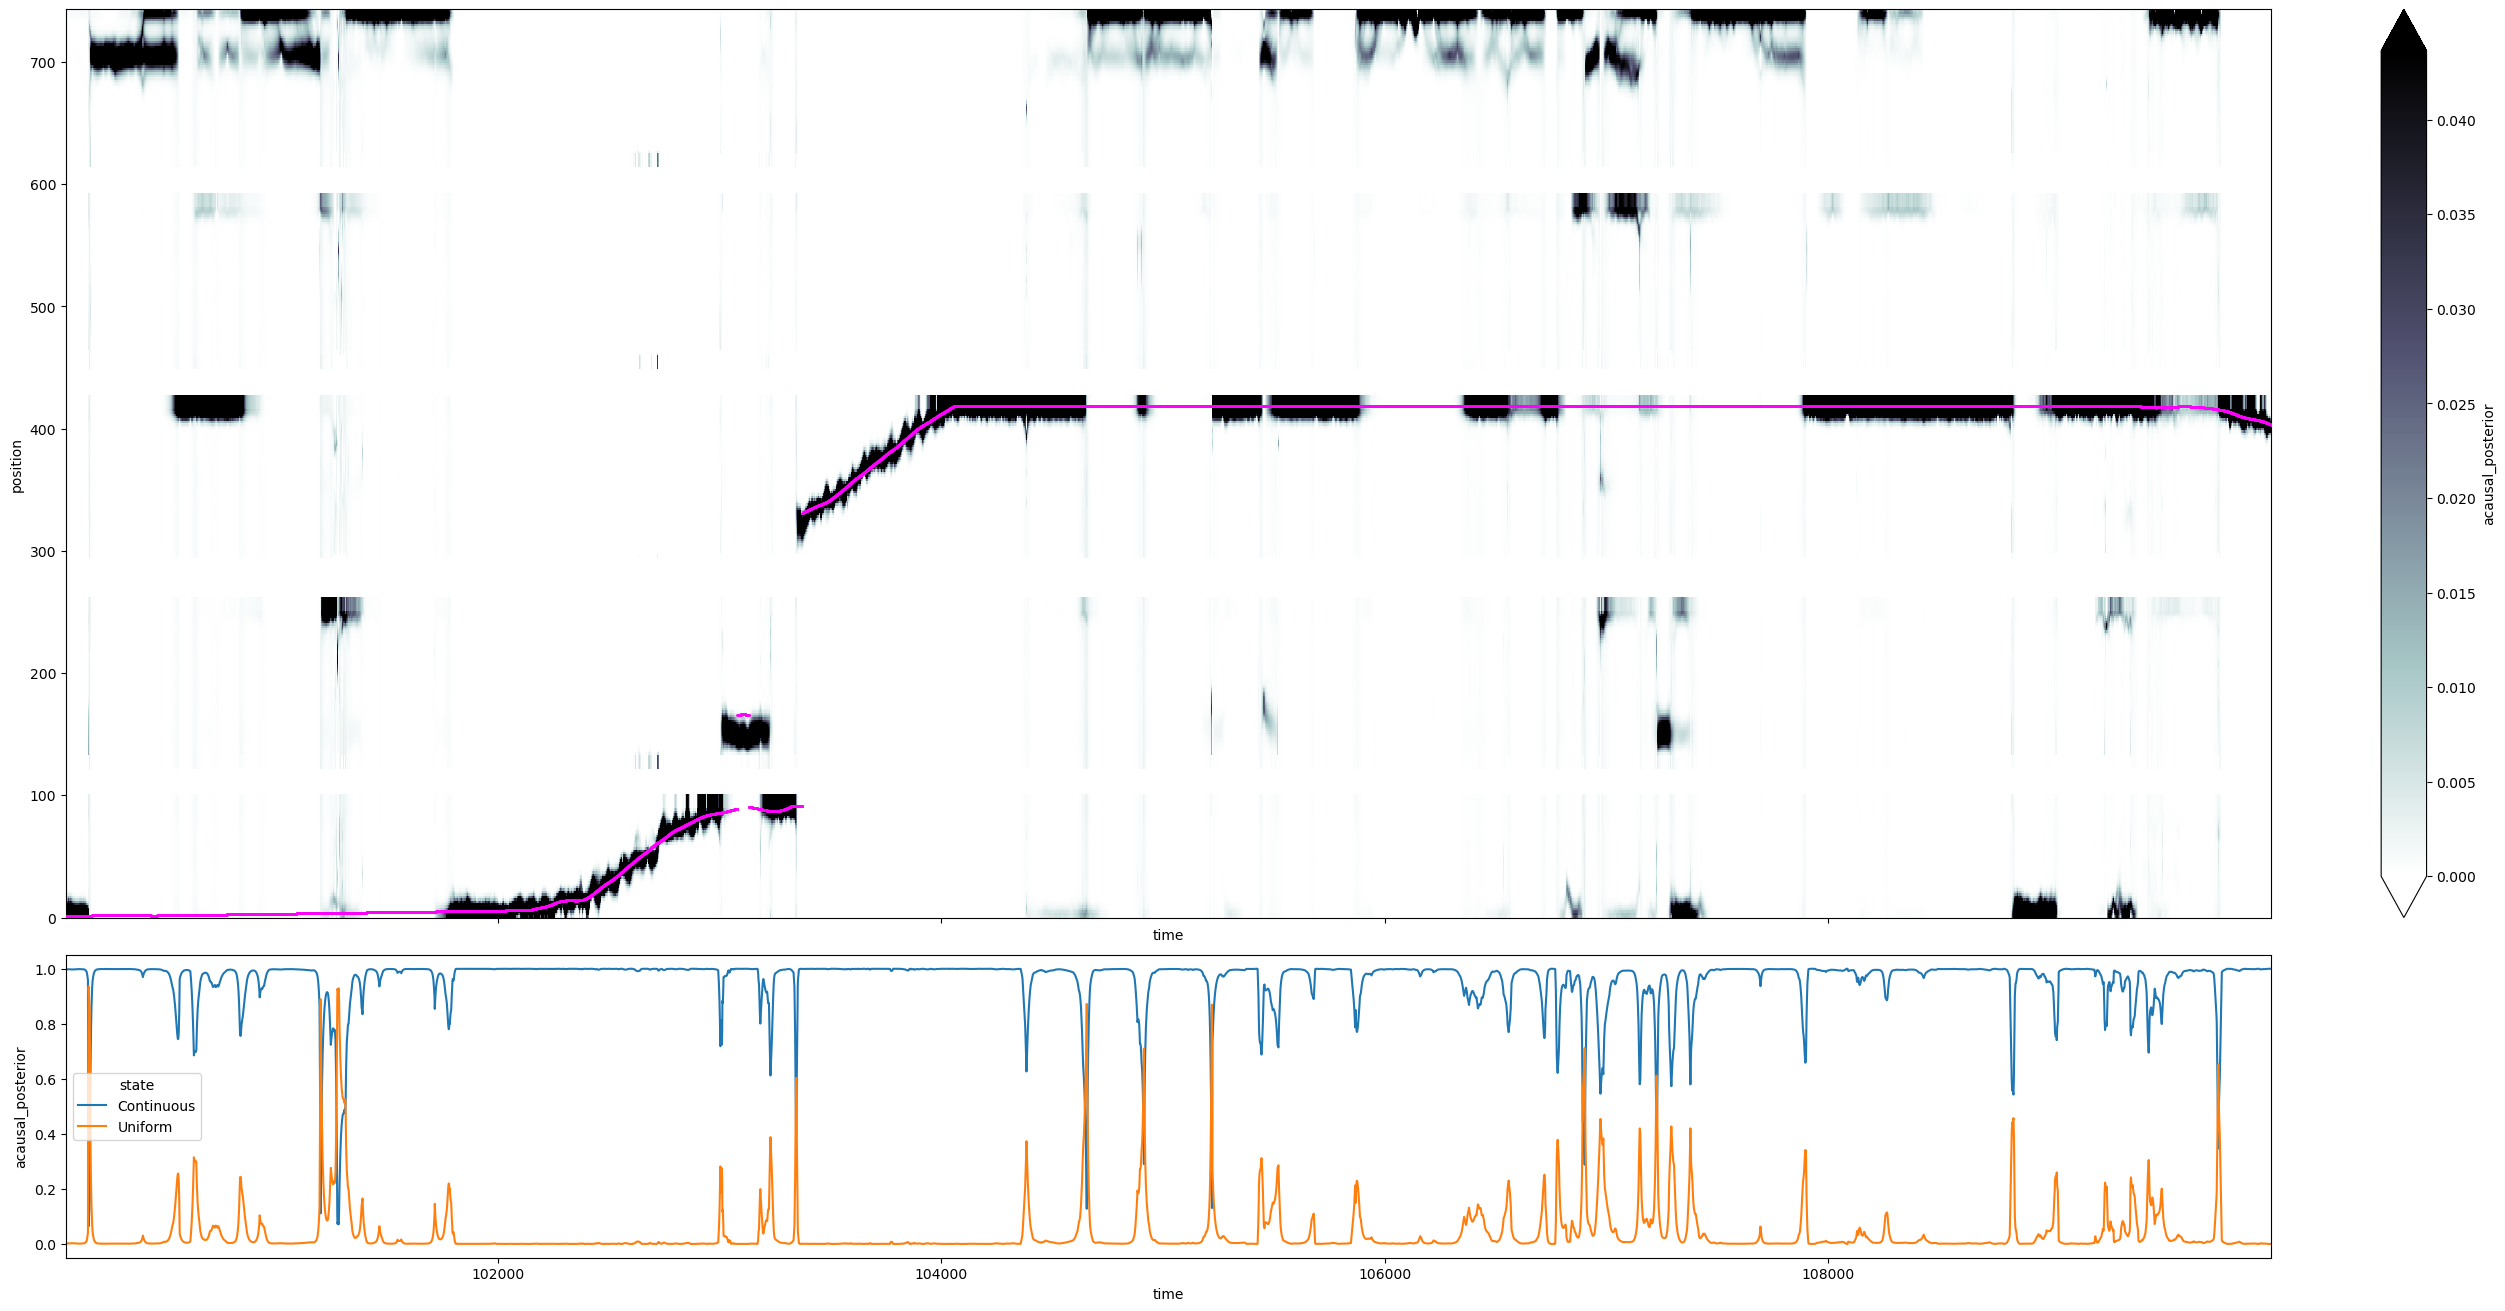

In [96]:
import matplotlib.pyplot as plt

time_slice = slice(100_050, 110_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(position_1d.iloc[time_slice].index,
                position_1d.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

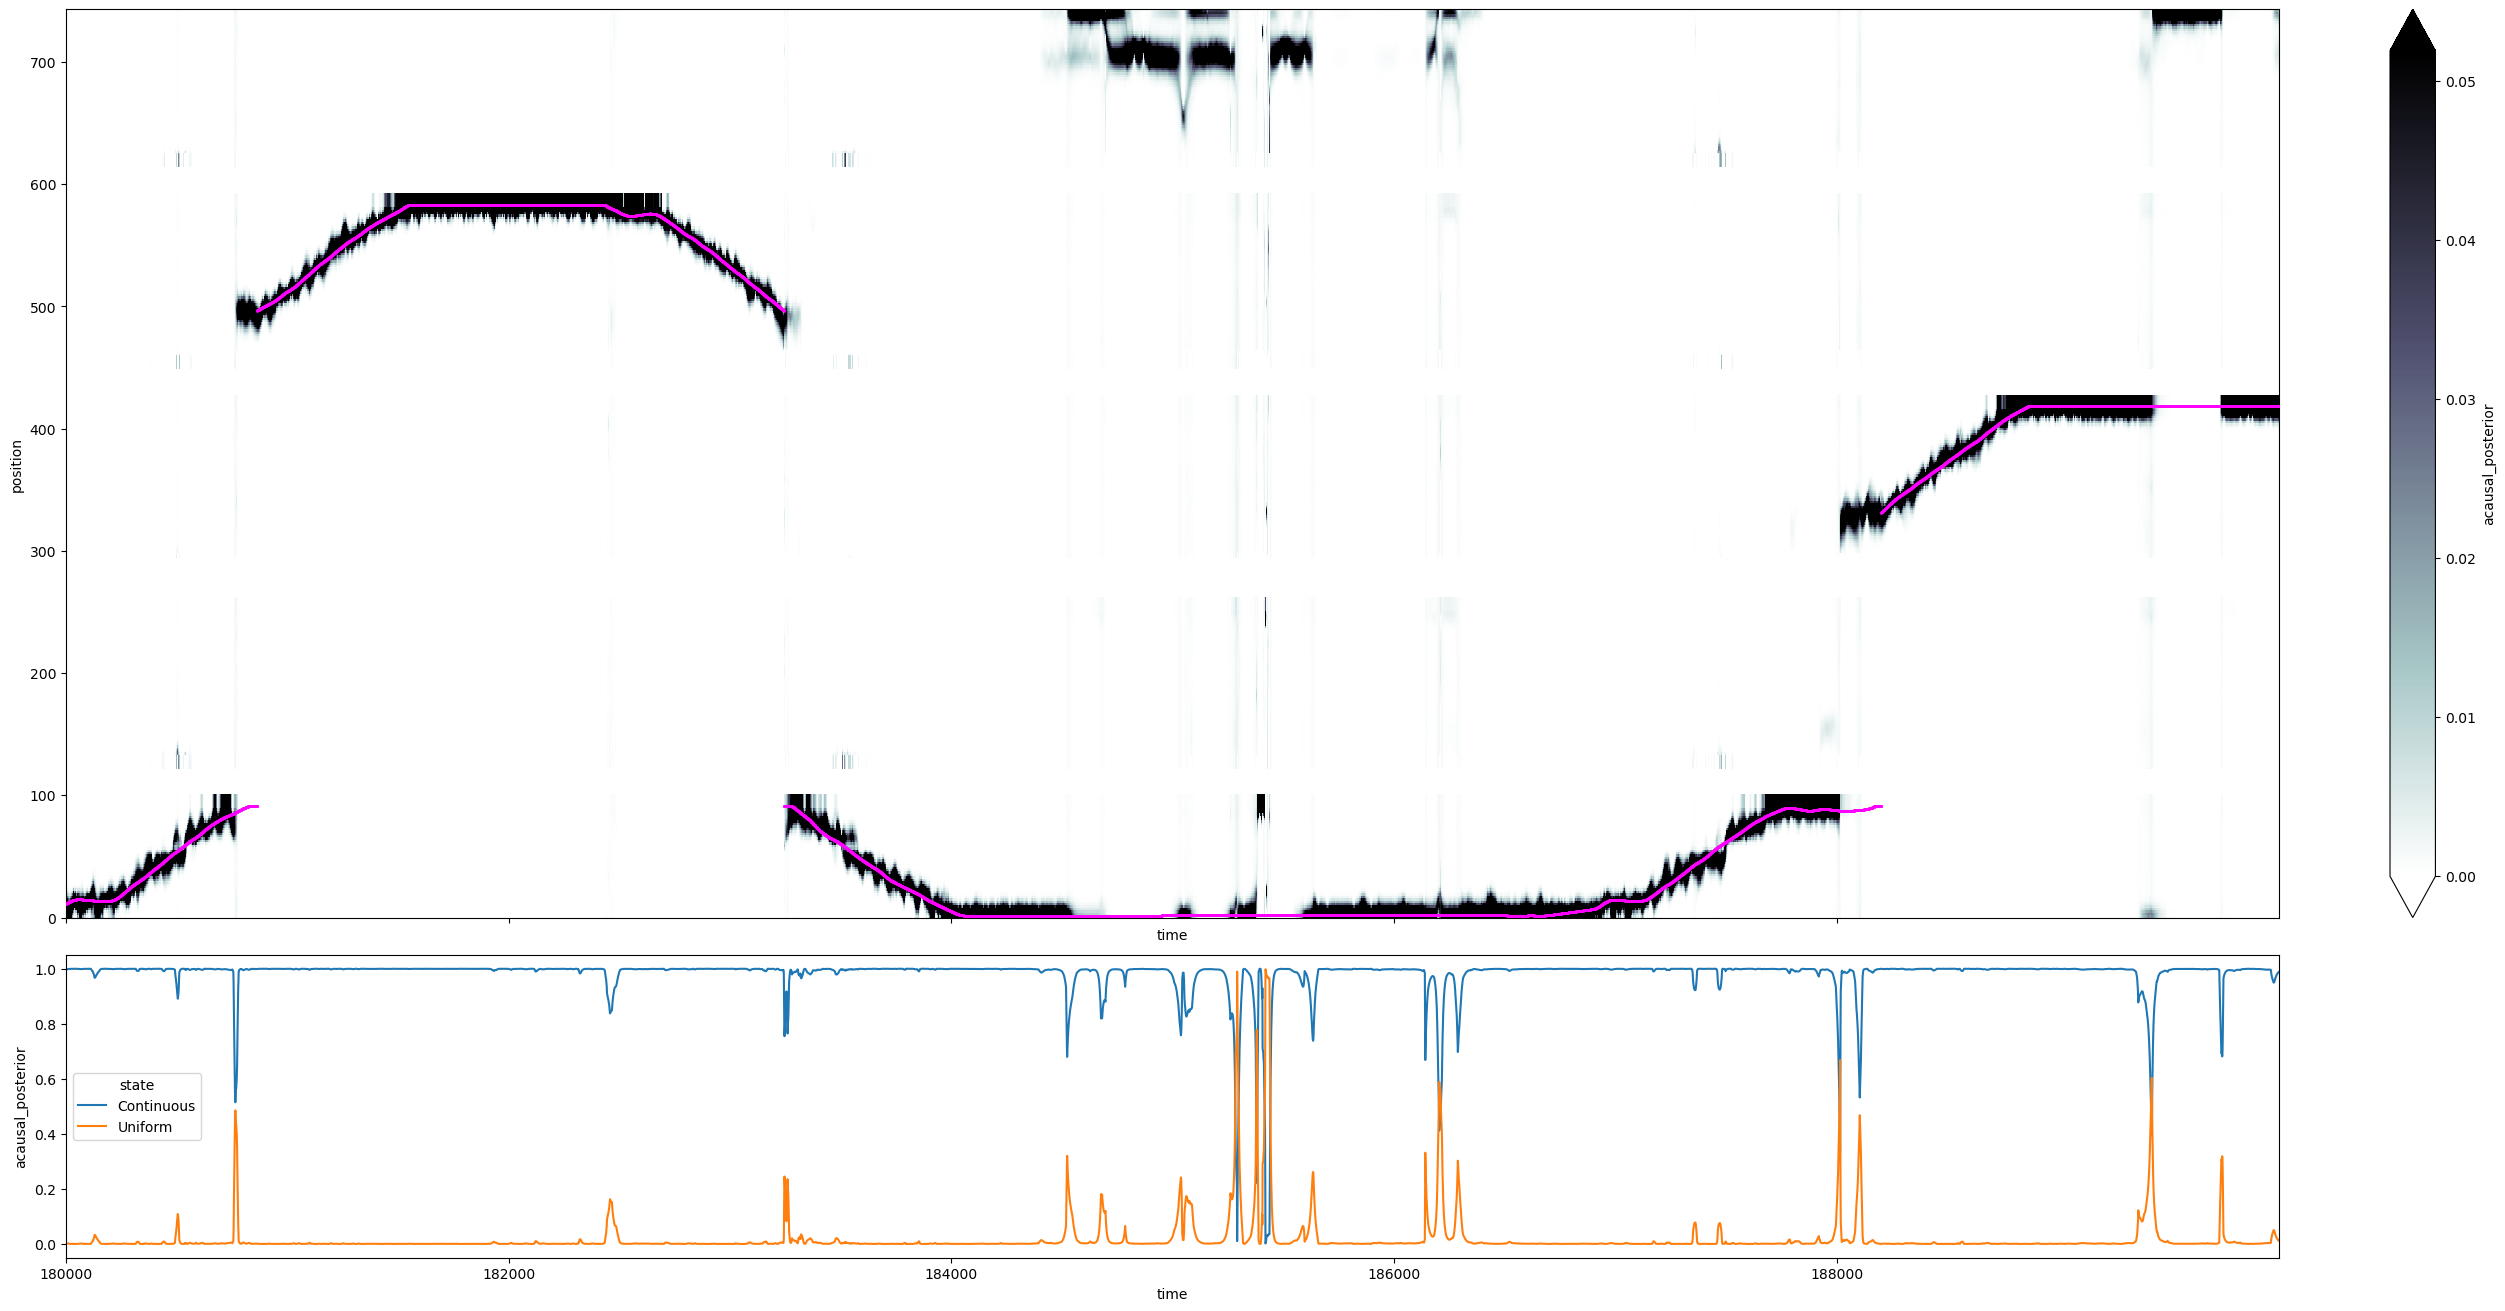

In [97]:
import matplotlib.pyplot as plt

time_slice = slice(180_000, 190_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(position_1d.iloc[time_slice].index,
                position_1d.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

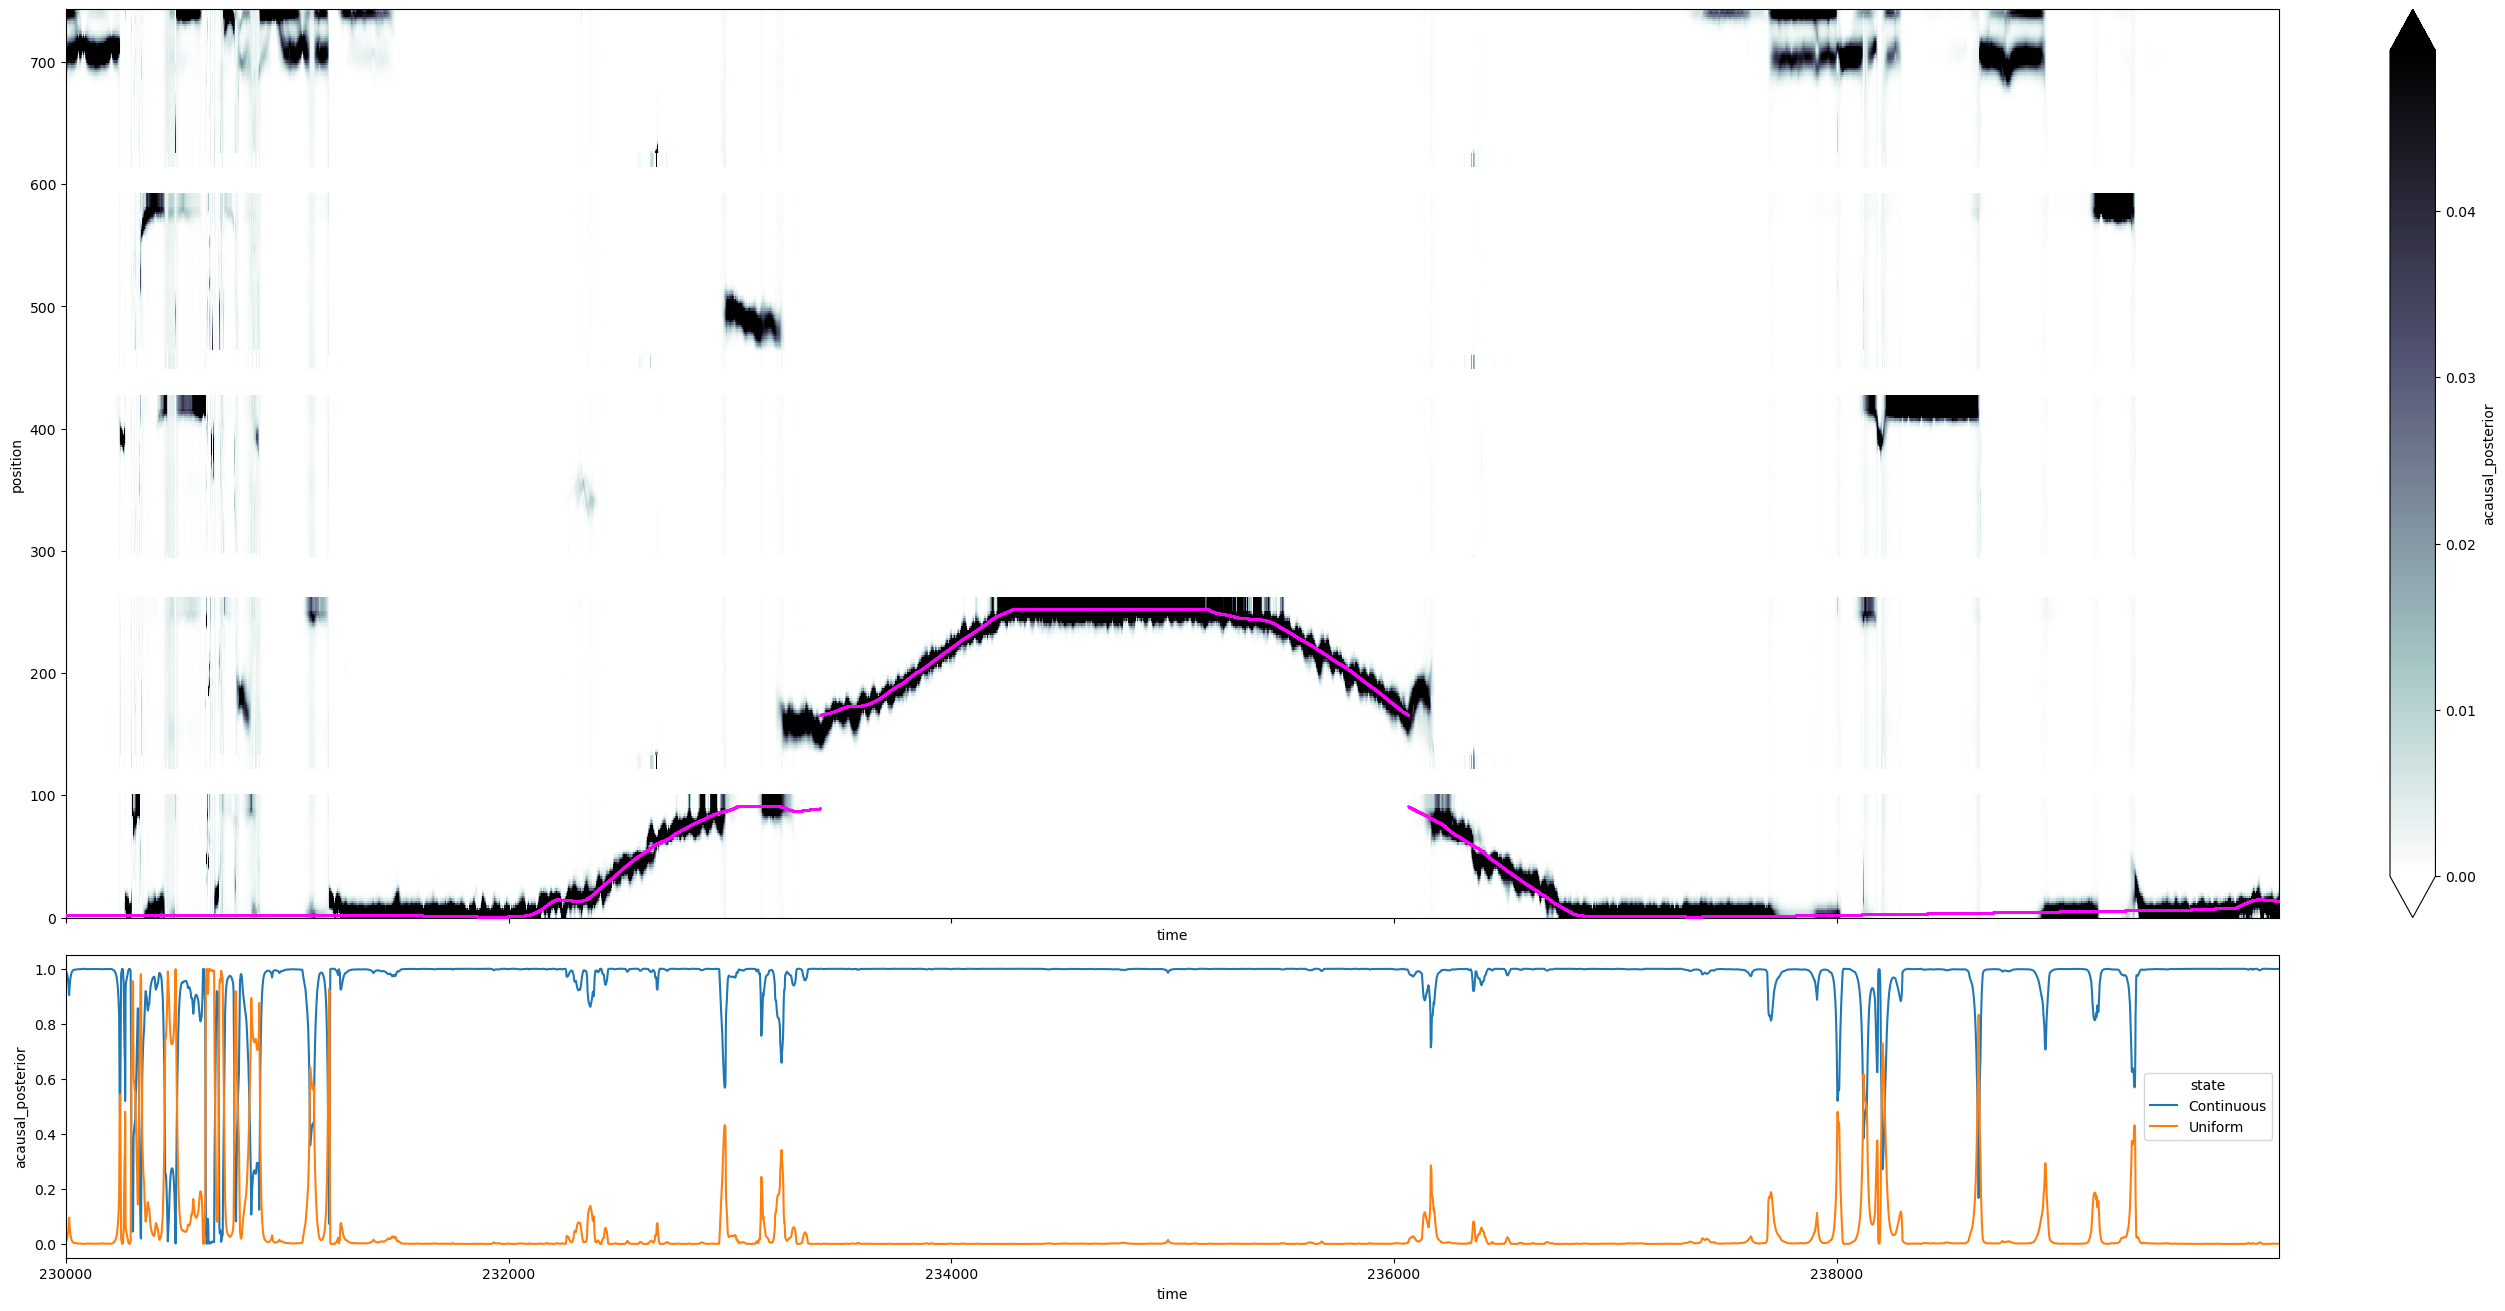

In [99]:
import matplotlib.pyplot as plt

time_slice = slice(230_000, 240_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(position_1d.iloc[time_slice].index,
                position_1d.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

# For all sessions

In [91]:
from trajectory_analysis_tools import get_trajectory_data, get_ahead_behind_distance

trajectory_data = get_trajectory_data(
    results.sum('state').acausal_posterior,
    track_graph,
    classifier,
    linear_position_df[['projected_x_position', 'projected_y_position']],
    linear_position_df.track_segment_id,
    position_info.head_orientation,
)

ahead_behind_distance = get_ahead_behind_distance(
    track_graph, *trajectory_data)
mental_position_edges = trajectory_data[-1]
mental_position_edge_id = np.asarray(
    [track_graph.edges[edge]['edge_id'] for edge in mental_position_edges])

NameError: name 'position_info' is not defined

In [30]:
from ripple_detection import get_multiunit_population_firing_rate

SAMPLING_FREQUENCY = 500

multiunit_spikes = (np.any(~np.isnan(marks.values), axis=1)
                    ).astype(float)
multiunit_firing_rate = pd.DataFrame(
    get_multiunit_population_firing_rate(
        multiunit_spikes, SAMPLING_FREQUENCY), index=marks.time,
    columns=['firing_rate'])

In [31]:
from ripple_detection import multiunit_HSE_detector

multiunit_high_synchrony_times = multiunit_HSE_detector(
    marks.time.values,
    multiunit_spikes,
    position_info.head_speed.values,
    sampling_frequency=SAMPLING_FREQUENCY,
    minimum_duration=0.015,
    zscore_threshold=2.0,
    close_event_threshold=0.000)

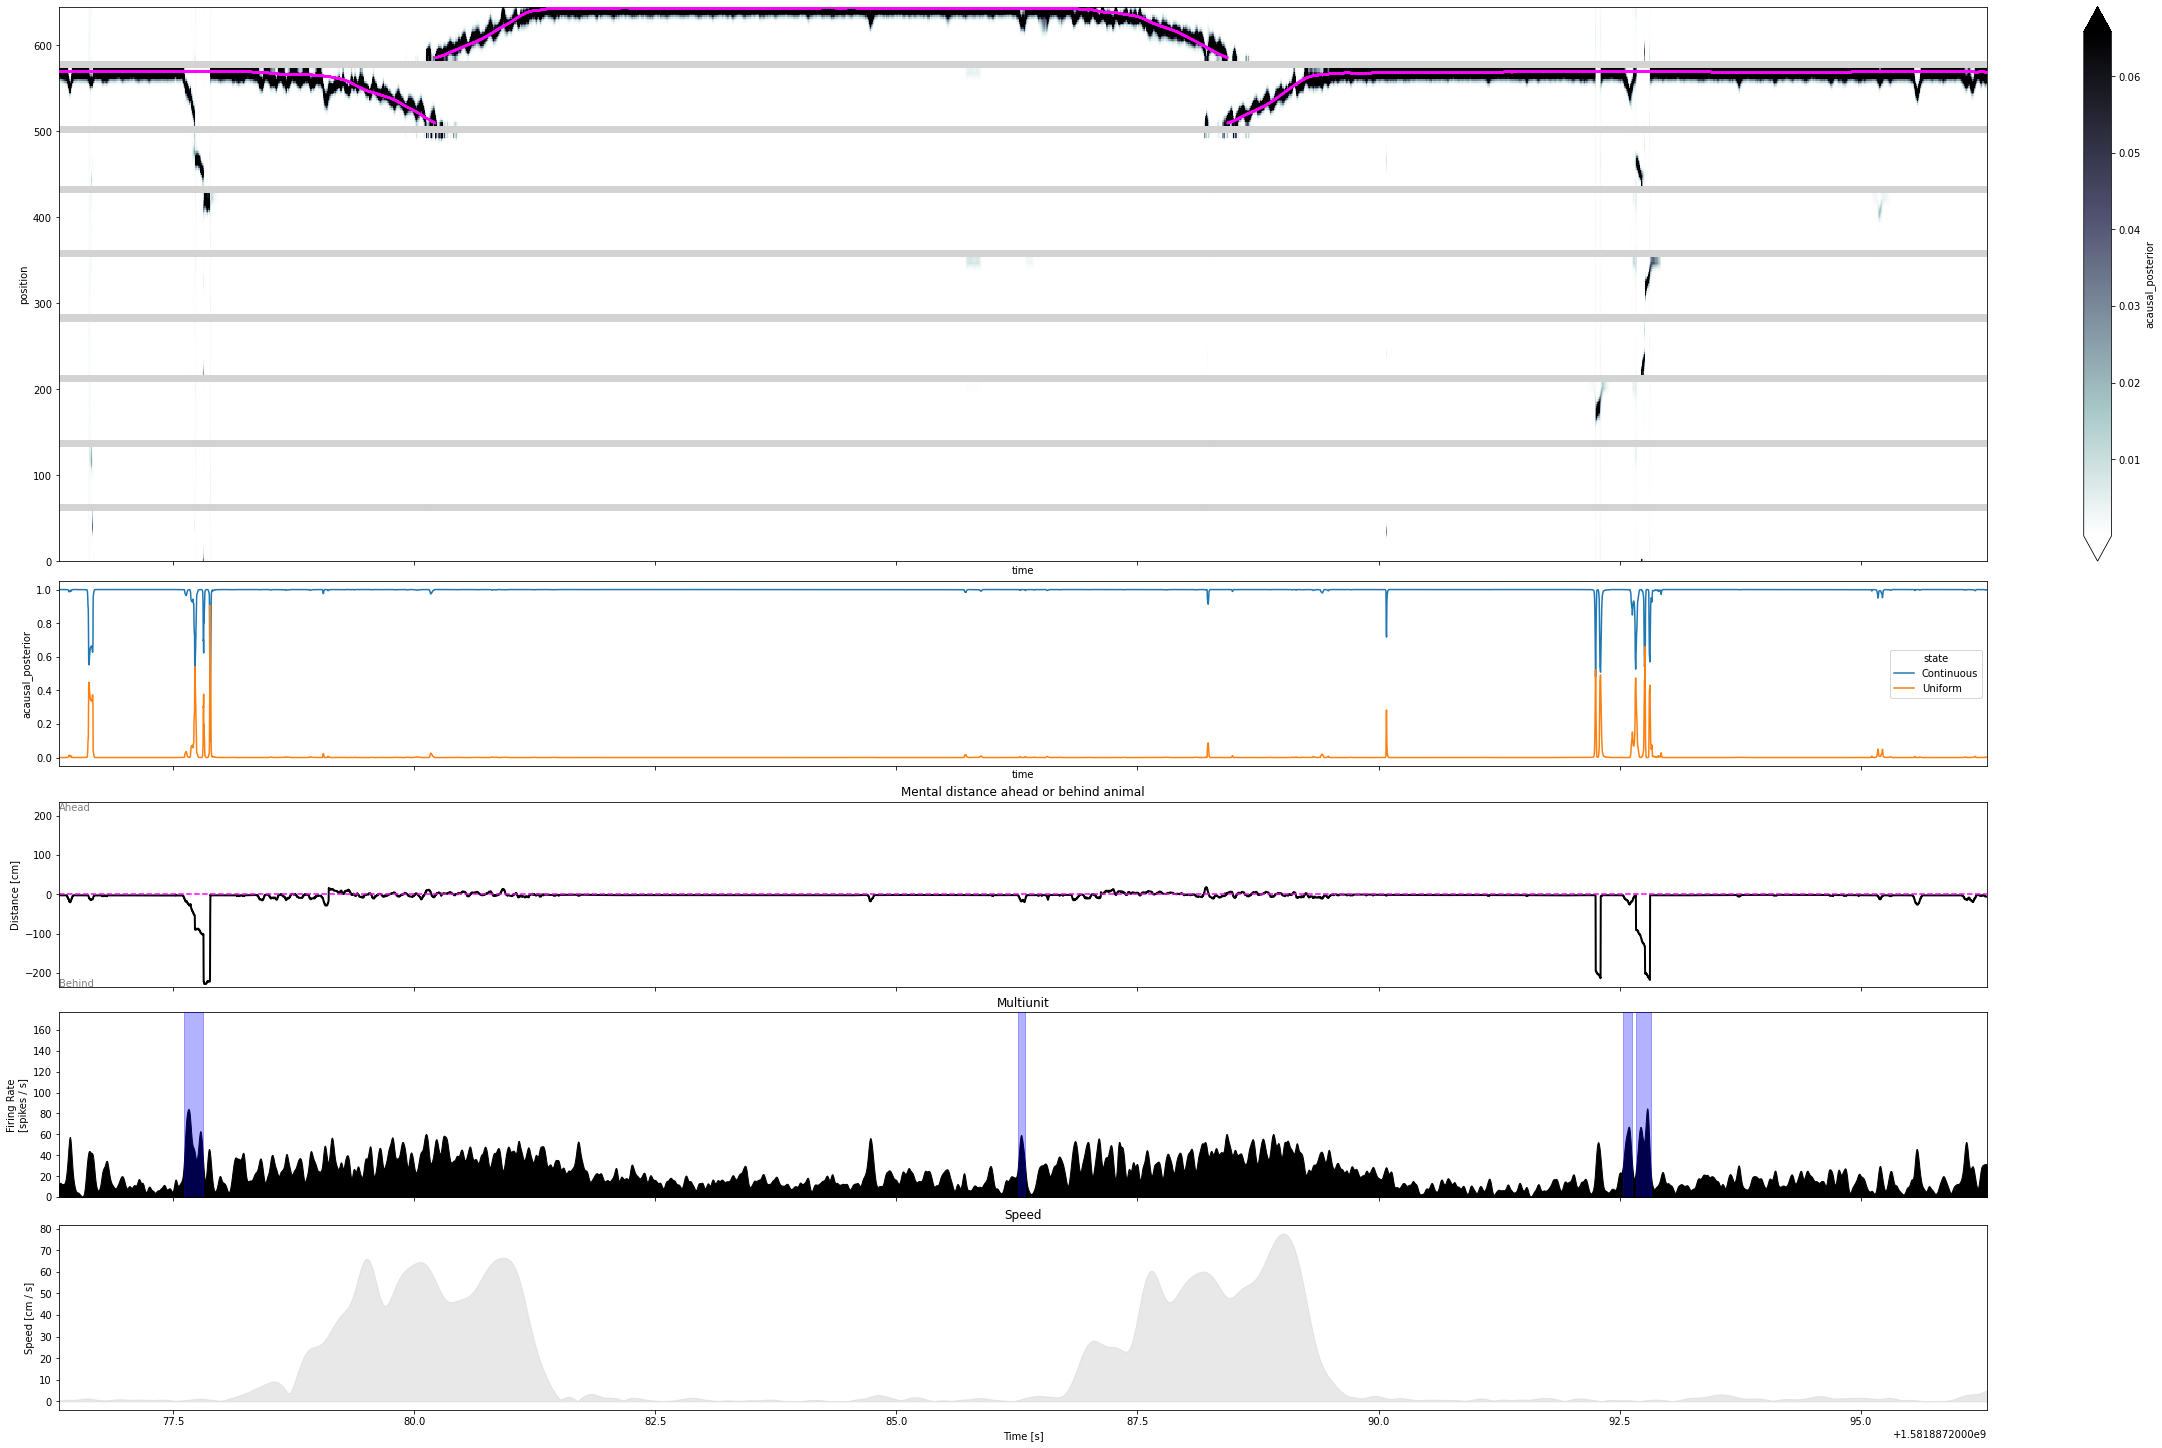

In [32]:
import matplotlib.pyplot as plt
import copy


def plot_classifier(
    time_slice,
    results,
    classifier,
    position_info,
    linear_position_df,
    ahead_behind_distance,
    multiunit_firing_rate,
    multiunit_high_synchrony_times,
    cmap='bone_r',
    figsize=(30, 20)
):

    cmap = copy.copy(plt.cm.get_cmap(cmap))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    fig, axes = plt.subplots(5, 1, figsize=figsize, sharex=True, constrained_layout=True,
                             gridspec_kw={"height_ratios": [3, 1, 1, 1, 1]},)

    time = results.isel(time=time_slice).time
    (results
     .isel(time=time_slice)
     .acausal_posterior
     .sum('state')
     .where(classifier.environments[0].is_track_interior_)
     .plot(x='time', y='position', ax=axes[0], robust=True, cmap=cmap))
    axes[0].scatter(time,
                    linear_position_df.iloc[time_slice].linear_position.values,
                    s=1, color='magenta', zorder=10)

    results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])
    axes[2].plot(time,
                 ahead_behind_distance[time_slice],
                 color="black", linewidth=2)
    axes[2].axhline(0, color="magenta", linestyle="--")
    axes[2].set_title("Mental distance ahead or behind animal")
    axes[2].set_ylabel("Distance [cm]")
    max_dist = np.max(np.abs(ahead_behind_distance)) + 5
    axes[2].set_ylim((-max_dist, max_dist))
    axes[2].text(time[0], max_dist - 1, "Ahead", color="grey", va='top')
    axes[2].text(time[0], -max_dist + 1, "Behind", color="grey")

    # ax 3
    axes[3].fill_between(
        multiunit_firing_rate.iloc[time_slice].index.values,
        multiunit_firing_rate.iloc[time_slice].values.squeeze(),
        color="black",
    )
    axes[3].set_ylabel("Firing Rate\n[spikes / s]")
    axes[3].set_title("Multiunit")
    axes[3].set_ylim((0.0, np.max(np.asarray(multiunit_firing_rate))))


    cur_multiunit_HSE = interval_list_intersect(
        np.asarray(multiunit_high_synchrony_times),
        np.asarray([(time[0], time[-1])]))

    for start_time, end_time in cur_multiunit_HSE:
        axes[3].axvspan(start_time, end_time, color='blue', alpha=0.3, zorder=10)

    # ax 4
    axes[4].fill_between(
        time,
        position_info.iloc[time_slice]
        .head_speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[4].set_title('Speed')
    axes[4].set_ylabel("Speed [cm / s]")
    axes[4].set_xlabel("Time [s]")
    

time_slice = slice(180_000, 190_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)

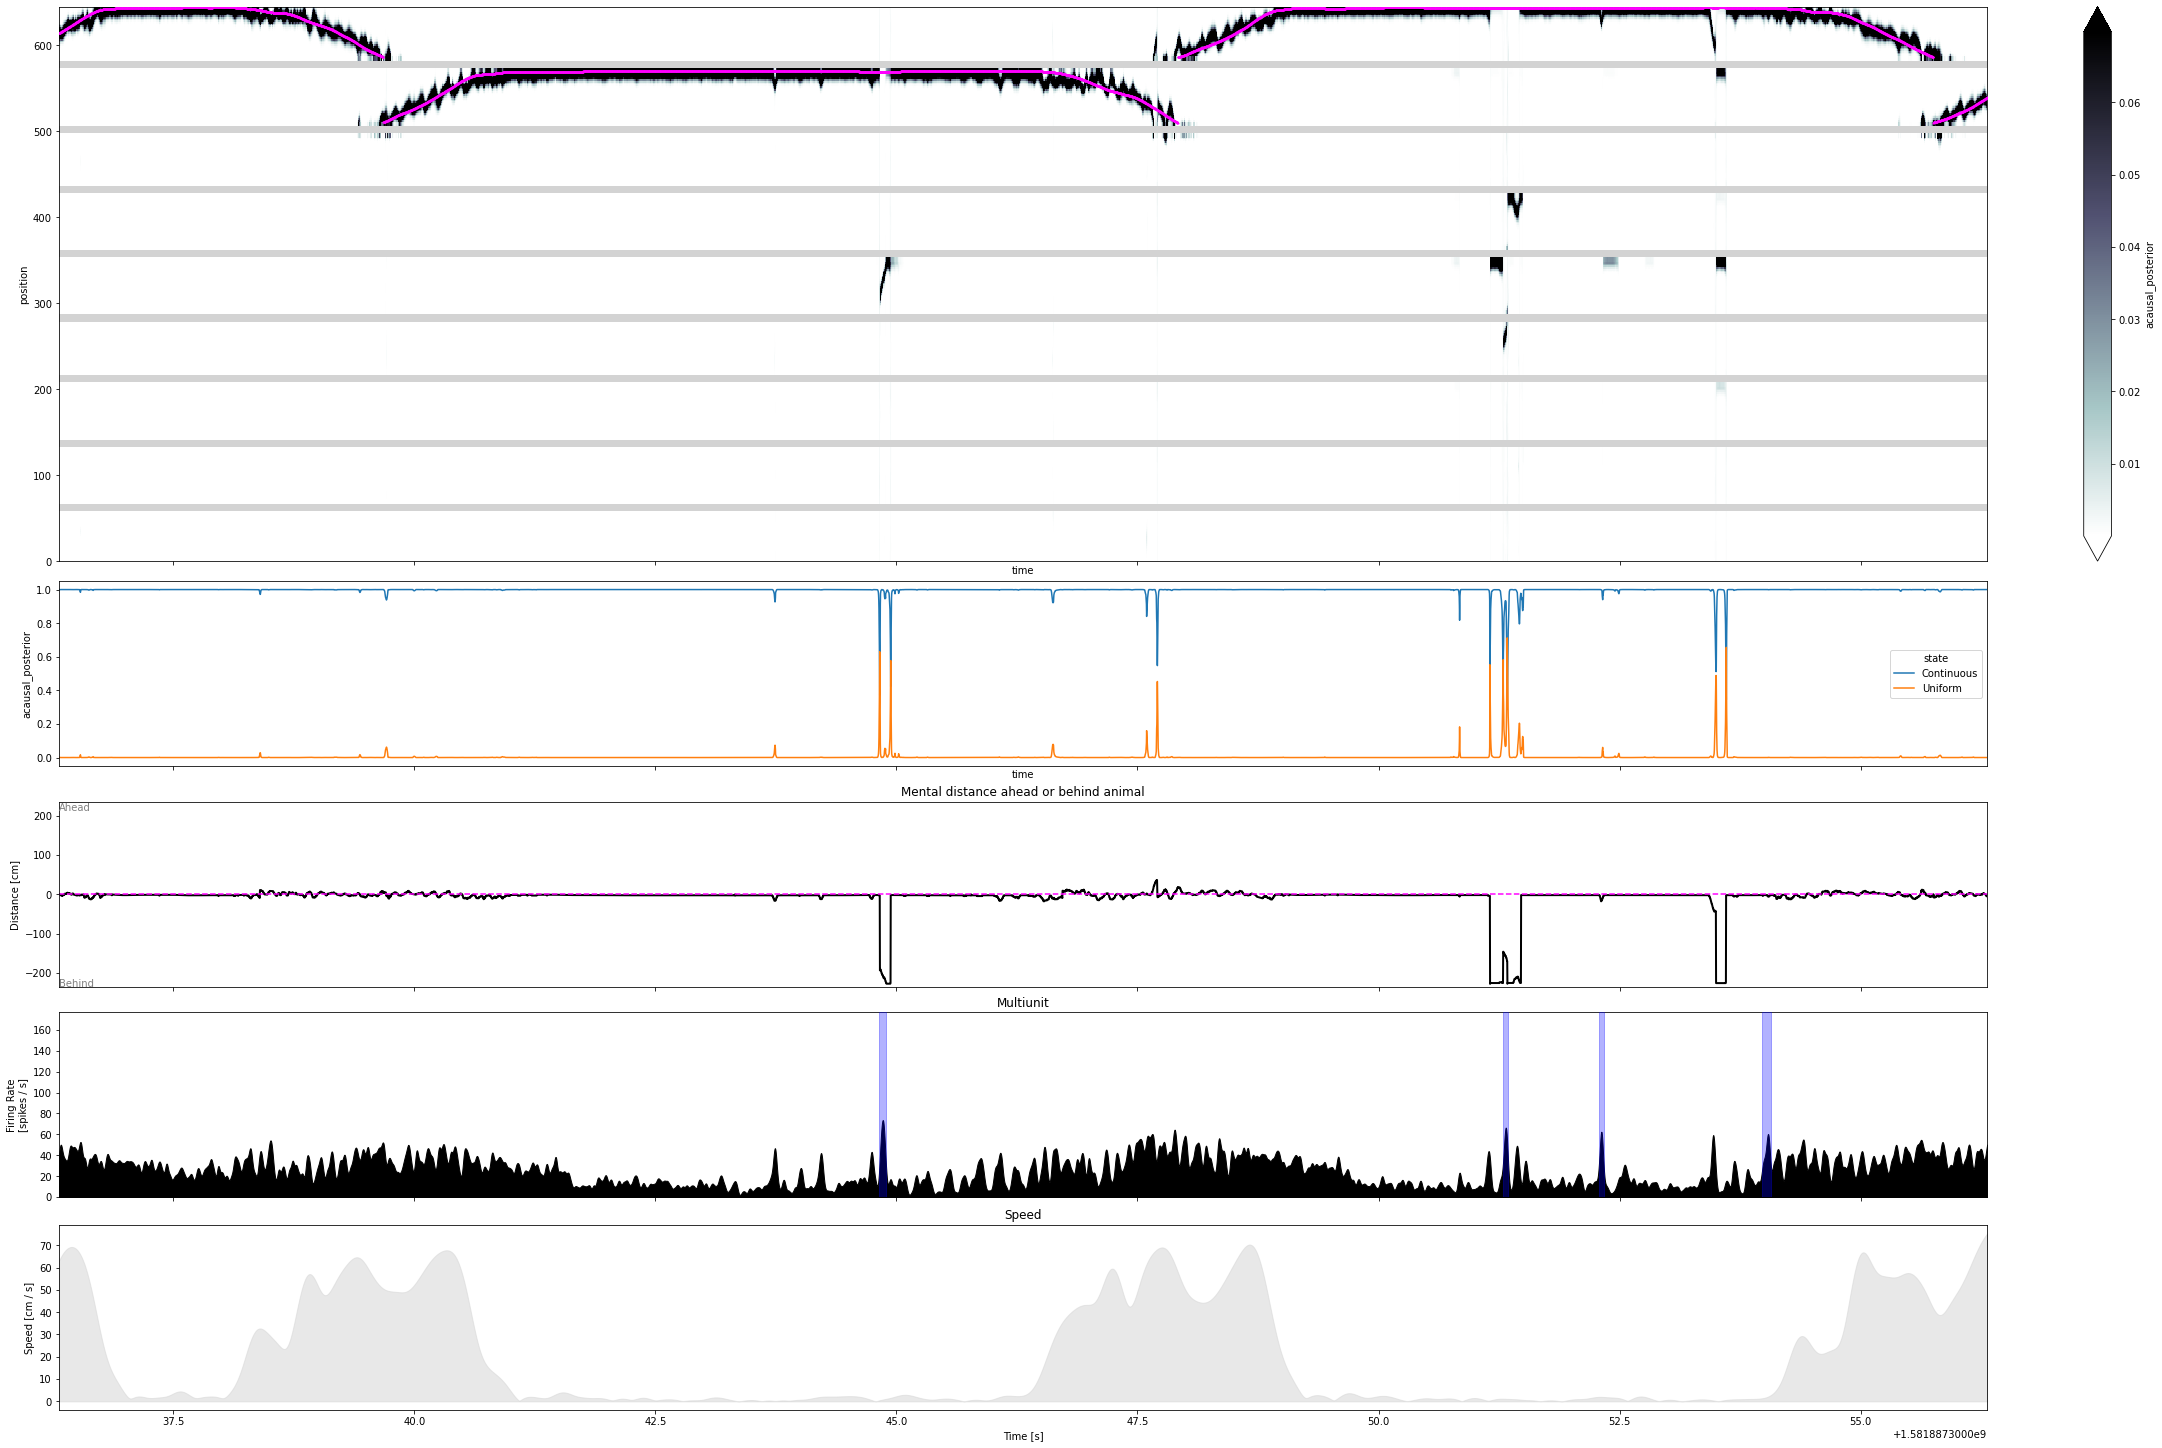

In [33]:
time_slice = slice(210_000, 220_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)

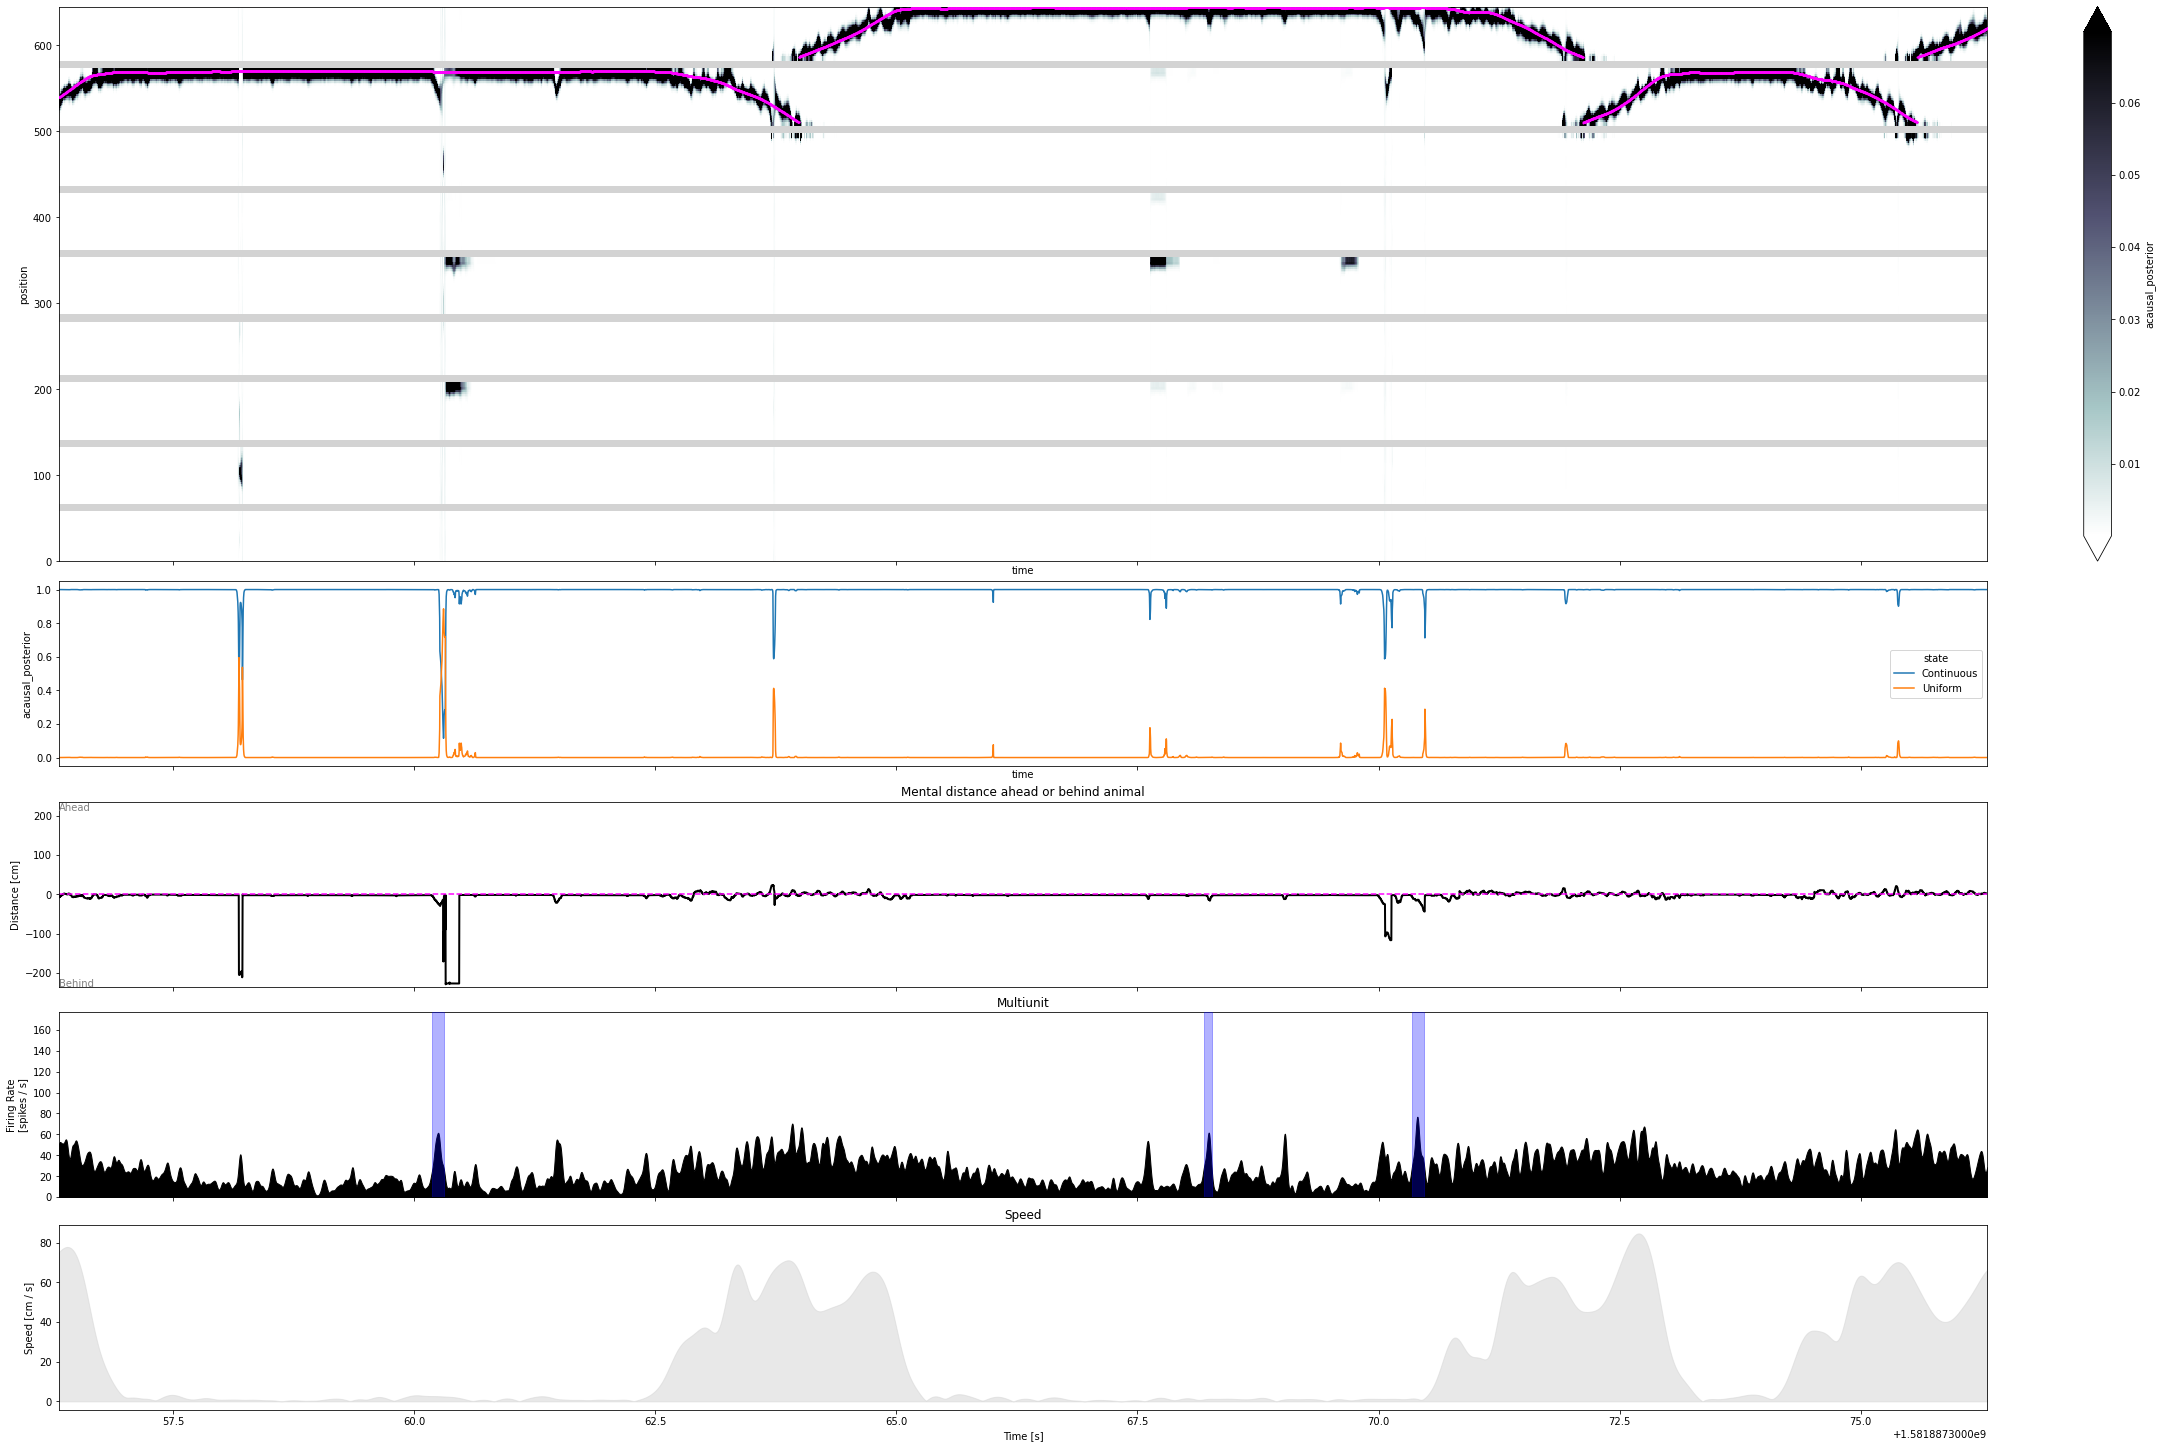

In [34]:
time_slice = slice(220_000, 230_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)